# Milestone 3

In [ ]:
# Install missing packages
#%pip install cpi

In [194]:
#we import all the necessary librairies here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from raceplotly.plots import barplot

from scipy import stats
from scipy.stats import f_oneway
from scipy.stats import chi2_contingency
import statsmodels.formula.api as smf
from community import community_louvain

import ast
from datetime import datetime
import cpi

import dash
from dash import dcc, html
from dash.dependencies import Input, Output

import networkx as nx
from tqdm import tqdm


# # Make sure that we have the good rate for computing the inflation
# cpi.update()


In [ ]:
#data paths
data_path = './data/'
cmu_path = data_path+'MovieSummaries/'
acl_persona_path = data_path+'ACL_personas_dump/personas/'

In [ ]:
# color for data visualisation

# Single color graph
SING_COLOR = 'cornflowerblue'

# Comparison color graphs
COMP_COLOR1 = ['cornflowerblue', 'orange'] #use color_discrete_map when plotting
COMP_COLOR2 = px.colors.qualitative.Pastel #use color_discrete_sequence when plotting

# Multi color graph (not necessary comparison)
MULT_COLOR = px.colors.qualitative.T10 #use color_discrete_sequence when plotting

# Template for graph
TEMPLATE = 'seaborn'

## 1. Data cleaning and preprocessing

In this part we will import, clean and transform the data we will use for later analysis.

- We will first create a more complete movie dataset by merging the data from cmu with some useful data from imdb.
- Then, the dataset is cleaned and transformed to be used for later analysis.
- We perform the same cleaning for the character dataset.
- Once all the datasets are ready, we compute a fame score to quantisize the sucess of an actor. This a first version of the fame score that we will show as satisfying enough for the pre-analysis. It will be improved based on futur milestone with more complex computations.
- Finally, we load the dataset from ACL_personas_dump and merge it with the character one to get associate personas to each character.   

#### 1.1 Movie dataset

Let's first have a look at the cmu movie dataset more in details to see what we can do with it.

In [ ]:
#Import the cmu movie dataset and print a sample of 5 random row in the dataset
cmu_movie_cols = ['wikiID',
                  'freebase_movID',
                  'movie_name',
                  'release_date',
                  'boxoffice',
                  'runtime',
                  'language',
                  'country',
                  'genre']

cmu_movies = pd.read_csv(cmu_path+'movie.metadata.tsv', sep='\t', names=cmu_movie_cols)
cmu_movies.sample(5)

In [ ]:
cmu_movies.info()

The first thing we see here is that we do not have a lot of boxoffice data for the movies. However we need a way to asses the success of a movie for our analysis (we will later use this notion to compute a fame score for the actors).

To solve this issue we decided that we will use the imdb rating and number of votes as a proxy for the success and popularity of a movie.

In [ ]:
# As the dataset is pretty big, we won't bother importing columns that we don't need later to save memory space
col_to_load = ['tconst','primaryTitle','startYear']
col_dtype = {'tconst': str, 'primaryTitle': str, 'startYear': 'Int64'}

imdb_movies = pd.read_csv(data_path+'title_basics.tsv', usecols=col_to_load, sep='\t', na_values=['\\N'], 
                          dtype=col_dtype)
imdb_ratings= pd.read_csv(data_path+'title_ratings.tsv', sep='\t')

# As this dataset is a way for us to get the title of the rating dataset, we will drop all 
# the rows that have NaN values in the primaryTitle column.
imdb_movies.dropna(subset=['primaryTitle'], inplace=True)


Now let's combine the two to have a new dataset containing the title of the movie and its rating.

In [ ]:
imdb_movies_ratings = imdb_movies.merge(imdb_ratings,how='inner',on='tconst')
imdb_movies_ratings.sample(5)

Now that we have a dataset with the title of the movie and its rating, we can clean the duplicates and the movies with no rating.

In [ ]:
imdb_movies_ratings.primaryTitle = imdb_movies_ratings.primaryTitle.str.lower()
imdb_movies_ratings.drop_duplicates(subset=['primaryTitle','startYear'],inplace=True)
imdb_movies_ratings.dropna(subset=['averageRating'], inplace=True)

Now let's merge it to the cmu dataset in order to have a dataset with all the information we need.

In [ ]:
#first we lower the title also in the cmu dataset
cmu_movies.movie_name = cmu_movies.movie_name.str.lower()

#then we retrieve the release year of the movies in the cmu dataset
cmu_movies['release_year'] = pd.to_numeric(cmu_movies.release_date.astype(str).str[:4], errors='coerce') \
                               .astype('Int64')
cmu_movies.dropna(subset=['release_year'], inplace=True)

cmu_imdb_movies = cmu_movies.merge(imdb_movies_ratings,left_on=['movie_name','release_year'],
                                                       right_on=['primaryTitle','startYear'])
cmu_movies = cmu_imdb_movies.drop(columns=['primaryTitle','startYear','release_year']).copy()
cmu_movies.sample(5)

Now that we have all the information we need, we can start working on making the dataset more usable for our analysis.

In [ ]:
cmu_movies.info()

As we can see here the date are not in a very usable format. We will need to convert them to a datetime format.

In [ ]:
cmu_movies['release_date'] = cmu_movies['release_date'].apply(pd.to_datetime)

#we check if we have coherent date
cmu_movies.release_date.describe()

We will now check the distribution of the movies we have through the years. and we will drop the years that have too few movies.

In [ ]:
grouped_year = cmu_movies.groupby(cmu_movies.release_date.dt.year).agg(number_films=('movie_name','count')) \
                         .reset_index()

plt.figure(figsize=(8, 4))
plt.bar(grouped_year['release_date'], grouped_year['number_films'], color='skyblue', edgecolor='black')
plt.title('Number of Films per Year')
plt.xlabel('Year')
plt.ylabel('Number of Films')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

It seems the number of movies per year increases with years. Let's see a bit more in details how many years have less than 100, 500, 1000 movies.

In [ ]:
# Print the years with less than 100, 500, and 1000 films
years_less_than_100 = grouped_year[grouped_year['number_films'] < 100]['release_date']
years_less_than_500 = grouped_year[grouped_year['number_films'] < 500]['release_date']
years_less_than_1000 = grouped_year[grouped_year['number_films'] < 1000]['release_date']

print(f'Number of years with less than 100 films: {len(years_less_than_100)}')
print(f'Number of years with less than 500 films: {len(years_less_than_500)}')
print(f'Number of years with less than 1000 films: {len(years_less_than_1000)}')

# Print the year with the max number of movies
max_films_year = grouped_year.loc[grouped_year['number_films'].idxmax(), 'release_date']
max_films_count = grouped_year['number_films'].max()
print(f'The year with the max number of films is: {max_films_year:.0f} with {max_films_count} films')

We see that there are not that much years with less than 100 movies. We will drop them from our dataset, in order to have more significant results when we will do year based analysis.

In [ ]:
# In the original CMU dataset remove the rows with release year with less than 100 films
years_to_remove = grouped_year[grouped_year['number_films'] < 100]['release_date'].tolist()
cmu_movies = cmu_movies[~cmu_movies.release_date.dt.year.isin(years_to_remove)].copy()

We have also the problem that so far the values in the columns 'language', 'country' and 'genre' are still in a object format and not easily usable. We will need to convert them to a more usable format. For an easy access to those values later we will interpret them as dictionaries that we'll convert to a list format since we do not need the keys (that come from freebase).

In [ ]:
# Transform the object dtype into list of values:
# We use ast.literal_eval to interpret the string as a dictionnaries, we take only their values and 
# we convert it to a list
cmu_movies['language'] = cmu_movies['language'].apply(lambda x: list(ast.literal_eval(x).values())) 
cmu_movies['country'] = cmu_movies['country'].apply(lambda x: list(ast.literal_eval(x).values()))
cmu_movies['genre'] = cmu_movies['genre'].apply(lambda x: list(ast.literal_eval(x).values()))

# Check the max number of values in each list(i.e. the max number of languages, countries and genres for a movie)
print(f'The max number of values in a single list for language is {cmu_movies["language"].apply(len).max()}')
print(f'The max number of values in a single list for country is {cmu_movies["country"].apply(len).max()}')
print(f'The max number of values in a single list for genre is {cmu_movies["genre"].apply(len).max()}')

In [ ]:
# Cleaned version of the CMU dataset
cmu_movies

In [ ]:
cmu_movies.info()

We see here that we have enough data for our analysis.

#### 1.2 Characters dataset

Now that we have a usable and clean dataset for the movies we will interest ourselves in the character dataset. To do that let first have a look at the dataset.

In [ ]:
cmu_character_cols = ['wikiID',
                      'freebase_movID',
                      'release_date',
                      'character_name',
                      'actor_birth',
                      'actor_gender',
                      'actor_height',
                      'actor_ethnicity',
                      'actor_name',
                      'actor_age_at_release',
                      'freebase_char_actor_map',
                      'freebase_charID',
                      'freebase_actorID']

cmu_character = pd.read_table(cmu_path+'character.metadata.tsv', names=cmu_character_cols)

ethnicity_map = pd.read_table(data_path+'ethnicities_data.tsv', sep='\t', index_col=0).to_dict()['Ethnicities']
cmu_character['actor_ethnicity'] = cmu_character['actor_ethnicity'].map(ethnicity_map)
ethnicity_map = pd.read_table(data_path+'ethnicity_group_data.tsv', sep='\t', index_col=0).to_dict()['Ethnic Group']
cmu_character['actor_ethnicity'] = cmu_character['actor_ethnicity'].map(ethnicity_map)

cmu_character.sample(5)

In [ ]:
cmu_character.info()

We will first drop any null value we have on the wikiID column or in the freebase_actorID column since we don't want character without actor or movie, we also drop the dupplicates if we have more than one character for the same actor in the same movie.

In [ ]:
cmu_character.dropna(subset=['wikiID','freebase_actorID'], inplace=True)
cmu_character.drop_duplicates(subset=['wikiID','freebase_actorID'], inplace=True)

We will now create a dataset containing the information about the actors and the movies they played in.

In [ ]:
actor_movie = cmu_character.drop(columns='release_date', axis=1) \
                           .merge(cmu_movies[['wikiID','averageRating','numVotes','release_date','tconst']],
                                  on='wikiID',how='inner')
actor_movie.head(5)

In [ ]:
# We also add the principal actors for each movie
imdb_principals = pd.read_csv(data_path+'name_principals.csv')
imdb_principals.primaryName  = imdb_principals.primaryName.str.lower()
imdb_principals['is_principal'] = 1

actor_movie = actor_movie.merge(imdb_principals,
                                how="left",
                                left_on=['tconst',actor_movie.actor_name.str.lower()],
                                right_on=['tconst','primaryName']).drop(columns=['tconst','primaryName'])
actor_movie['is_principal'].fillna(0, inplace = True)

cmu_character = actor_movie.drop(columns=['averageRating','numVotes']).copy()
cmu_character

Now that we a cleaned dataset of character with the corresponding fame score of each actor, we would like that have more information on the character the actor is playing in this movie. For that we will use the persona dataset to be able later to understand the relation between the character and the actor. 

In [ ]:
acl_persona_cols = ['entity_id',
                    'wikiID',
                    'movie_name',
                    'entity_name',
                    'full_entity_name',
                    'entity_num_event',
                    'persona',
                    'final_posterior']

acl_persona = pd.read_table(acl_persona_path+'25.100.lda.log.txt', header=None, names=acl_persona_cols)
acl_persona.sample(5)

We want now to populate our cmu_character dataframe with those informations about the personas.

In [ ]:
cmu_character = cmu_character.merge(acl_persona[['entity_id','persona']], 
                                    left_on='freebase_char_actor_map', 
                                    right_on='entity_id', how='left').drop(columns='entity_id')

# Print the final dataset
cmu_character

In [ ]:
cmu_character.info()

# Fame score computation

First consider the data we have for each movies. We have the number of votes, the rate, the principal actors and also the date of release. One can assume that an actor fame will increase after a good movie and then decrease exponentially while he is not appearing in any other movies. This is the kind of shape we expect for a fame score.

We can first evaluate the instantaneous fame of an actor in a specific movie. It should be related to all the parameters we mentionned. But one can note that the overall number of votes increase with the time so we need to rescale it.

In [ ]:
actor_movie.sample(5)

In [ ]:
votes_per_year = actor_movie[['release_date','numVotes']].groupby(actor_movie['release_date'].dt.year)[['numVotes']].agg("mean")
plt.scatter(votes_per_year.index,votes_per_year.numVotes)
plt.ylabel('Number of votes')
plt.show

In [ ]:
fig, axis = plt.subplots(1,3,figsize=(16,4))

axis[0].scatter(votes_per_year.index,votes_per_year.numVotes)
axis[0].set_title('Number of votes')

axis[1].scatter(votes_per_year.index,np.sqrt(votes_per_year.numVotes))
axis[1].set_title('Log (Number of votes)')

axis[2].scatter(votes_per_year.index,np.sqrt(votes_per_year.numVotes)/(votes_per_year.index-1900))
axis[2].set_title('Log (Number of votes) weighted by year')


plt.show()

In [ ]:
def instant_fame_score(row,data):
    year = row['release_date'].year
    rate = row['averageRating']
    votes = row['numVotes']
    is_principal = row['is_principal']

    instant_fameScore = rate * np.sqrt(votes) / (year-1900) * (1 + 0.2*is_principal)

    return instant_fameScore

actor_movie.sort_values(by=['freebase_actorID','release_date'], inplace=True)
actor_movie['instant_fameScore'] = actor_movie.apply(lambda x: instant_fame_score(x,actor_movie), axis=1)

In [ ]:
def get_fame_score(df, mode='before_after_films'):
    df = df.sort_values('release_date')

    dates = df['release_date'].to_numpy()
    if mode=='filmography':
        # every day between first and last films
        time_range = pd.date_range(dates[0], dates[-1], freq='D').to_list()
    elif mode=='before_after_films':
        # day before and release date of films
        time_range = np.hstack(list(map(lambda d: [d-pd.Timedelta(days=1),d-pd.Timedelta(days=0)], dates)))
    
    # make time_range non decreasing against cases with two films on the same day
    time_range = np.maximum.accumulate(time_range)
    #create a time_range for each films
    time_ranges = np.expand_dims(time_range, axis=0).repeat(axis=0,repeats=len(dates))
    #convert each time range to the number of days from film release date
    day_deltas = np.array(list(map(lambda x : list(map(lambda y,z: (y - dates[z]).days, x[1], [x[0]]*len(time_range))), enumerate(time_ranges))))
    # get exponential for each film
    exps = np.array(list(map(lambda x: np.exp(-x/4/365/5), day_deltas))) # CAN CHANGE DECAY HERE

    # mask exponential part before film release, treated in two cases to deal with films released on the same day issue
    if mode=='filmography':
        mask = exps>1
        exps[exps>1] = 0
    elif mode=='before_after_films':
        idx = np.indices(exps.shape)
        mask = idx[1]<2*idx[0]+1
        exps[mask] = 0
    
    exps = np.diag(df['instant_fameScore'])@exps # CAN CHANGE SCALING HERE
    mean_exps = np.array(list(map(lambda x: x[x!=0].mean() if len(x[x!=0])>0 else 0,exps.T)))
    return time_range, mean_exps

def fame_score(df, mode='before_after_films'):
    if mode=='filmography':
        return get_fame_score(df, mode='filmography')
    elif mode=='before_after_films':
        _, fame_scores = get_fame_score(df)
        df['fameScore_before']=fame_scores[2*np.arange(len(fame_scores)//2)]
        df['fameScore']=fame_scores[2*np.arange(len(fame_scores)//2)+1]
        df['fameScore_diff']=df['fameScore']-df['fameScore_before']
        return df

In [ ]:
# df=actor_movie.query("freebase_actorID=='/m/010p3'")
df = actor_movie[actor_movie['actor_name']=='Emma Watson']
time_range, sumexps = get_fame_score(df, 'before_after_films')

plt.plot(time_range, sumexps)
plt.show()

In [ ]:
actor_movie = actor_movie.groupby('freebase_actorID').apply(fame_score).reset_index(drop=True)
actor_movie.sample(5)

In [ ]:
cmu_character = cmu_character.merge(actor_movie[['freebase_movID','freebase_actorID','fameScore_before','fameScore','fameScore_diff']],on=['freebase_movID','freebase_actorID'],how='left')

In [ ]:
def plot_filmography(actor_name):
    '''
    This function plots the fame score of an actor along the years and the movies he played in
    '''

    filmography = cmu_character.query(f"actor_name=='{actor_name}'").sort_values('release_date')
    filmography = filmography.merge(cmu_movies[['wikiID','movie_name']], on='wikiID')

    # Create a scatter plot with go.Scatter
    fig = go.Figure()

    # Scatter plot for individual data points
    for idx, row in filmography.iterrows():
        fig.add_trace(go.Scatter(
            x=[row['release_date']],
            y=[row['fameScore']],
            mode='markers',
            marker=dict(symbol='circle', size=8, color=SING_COLOR, line=dict(color=SING_COLOR, width=1)),
            text=idx + 1, textposition='top right',
            name=f"{idx + 1} : {row['movie_name']}"
        ))

    # Line plot connecting the dots
    fig.add_trace(go.Scatter(
        x=filmography['release_date'],
        y=filmography['fameScore'],
        mode='lines',
        line=dict(color=SING_COLOR, width=1),
        showlegend=False  # Exclude this trace from the legend
    ))
    # Adjust the position of the annotations
    #fig.update_traces(textposition='top right', textfont_size=8)
    
    # Customize layout
    fig.update_layout(
        title=f'Fame score for {actor_name} along years',
        xaxis=dict(title='Year'),
        yaxis=dict(title='Fame Score after release'),
        legend=dict(title='Movie Name'),
        width=1000,
        height=700,
    )

    for idx, row in filmography.iterrows():
        fig.add_annotation(
            x=row['release_date'],
            y=row['fameScore'],
            text=str(idx + 1),
            showarrow=False,
            font=dict(size=8),
            xanchor='right',
            yanchor='bottom'
        )
        
    fig.show()

In [ ]:
plot_filmography('Christian Bale')

In [ ]:
cmu_character.to_csv('data/cmu_character.csv',index=False)

## 2. Data analysis

In the first part we will try to confirm if the fame score is a good indicator of the success of an actor.

Then we will start looking at the impact of different variables on the fame score in order to have a first glimpse at the way to succeed for an actor. This will allow us to assess the relevance of our problematic.

### 2.1 Relation between Box Office, Ratings, and Votes

For the moment we assumed that we could use the ratings as a proxy for the success of a movie. We will now try to see if this assumption is correct (if the ratings are correlated with the box office).

First we clean the cmu_movies to remove rows where either rating or boxoffice is missing.

In [ ]:
#Remove rows where both boxoffice and rating are missing
movies_df = cmu_movies.dropna(subset=['boxoffice','averageRating']).copy()

Before doing any analysis we will also adjust the boxoffice to take into account the inflation (i.e., values will be in 2020 dollars)

In [ ]:
movies_df["adj_boxoffice"] = movies_df.apply(lambda x: cpi.inflate(x["boxoffice"], x.release_date.year, to=2020), axis=1)

Let's now plot the boxoffice and the ratings taking into account the number of votes and the year of the movie, to see if there is any noticeable relation between those variables.

In [ ]:
# Divide data into 4 different time periods
periods = [(1901, 1940), (1941, 1980), (1981, 2000), (2001, 2020)]

# Create a new column 'period' in movies_df based on release year
movies_df['period'] = pd.cut(movies_df['release_date'].dt.year, bins=[period[0] for period in periods] + [np.inf],
                             labels=[f'{start}-{end}' for (start, end) in periods])


# Define the chronological order of the periods
category_order = [f'{start}-{end}' for (start, end) in periods]

# Scatter plot with larger dots based on 'numVotes' and color based on 'period'
fig = px.scatter(movies_df, x='averageRating', y='adj_boxoffice', size='numVotes',
                 color='period', color_discrete_sequence=MULT_COLOR,
                 opacity=0.5, labels={'numVotes': 'Number of Votes (Ks of votes)'},
                 category_orders={'period': category_order},
                 size_max=60,  # Set the maximum size of the dots
                 title='Adjusted Boxoffices with respect to rating (size dots based on number of votes)',
                 width=1000, height=1000,
                 log_y=True,  # Include log scale on the y-axis
                 template=TEMPLATE)  # Set the template to 'plotly_white' or choose another template
# Add a border around the dots
fig.update_traces(marker=dict(line=dict(color='black', width=1)),
                  selector=dict(mode='markers'))

fig.update_layout(
    legend=go.layout.Legend(
        title=dict(text='Period of time')  # Set the title of the legend
    ),
    xaxis_title='Average Rating on IMDb',  # Set the label for the x-axis
    yaxis_title='Adjusted Boxoffice [$ in 2020]'   # Set the label for the y-axis
)

fig.show()

From this plot we can derive several informations:

- Films with high number of votes tend to have high ratings and high boxoffice. This is not surprising since the more people watch a movie, the more likely it is to be good and to have a high boxoffice.
- The boxoffice seems to be higher with years.
- Films with low rating tend to have lower number of votes. Is it because people don't watch them based on their low ratings.

We will look at the correlation matrix to have a better understanding at the potential correlation we could find between the variables.

In [ ]:
# Calculate the correlation matrix
correlation_matrix = movies_df[['boxoffice', 'runtime', 'averageRating', 'numVotes', 'release_date']]\
                              .corr(method='pearson')

# Create a heatmap using Plotly
fig = go.Figure(data=go.Heatmap(
    z=correlation_matrix.values,  # Use the values from the DataFrame
    x=correlation_matrix.columns,
    y=correlation_matrix.index,
    colorscale='Blues',  # Use the 'Blues' colormap
    colorbar=dict(title='Correlation'),
    text=correlation_matrix.values.round(2),  # Annotate with rounded correlation values
    hoverongaps=False,
))

# Set layout properties
fig.update_layout(
    title='Correlation Heatmap',
    xaxis=dict(title='X-axis Label'),  # Replace 'X-axis Label' with your actual label
    yaxis=dict(title='Y-axis Label'),  # Replace 'Y-axis Label' with your actual label
    width=800,
    height=600,
)

fig.show()

This tends to show that the rating and the boxoffice are not correlated. However We have a big correlation between the number of votes, the boxoffice and the rating. 

We confirmed the fact that the more a film is voted the more it tends to have a high rating and a high boxoffice. As we use in the fame score the rating * log(number of votes) we can assume as a first approximation that we capture well the success of a movie an actor plays in and thus the fame of the actor gained thanks to this movie. 

The fact that we explicitly use the rating combined with the number of votes has the effect to give more fame to an actor that plays in "good" movies, movies with high ratings (it is more important for an actor to play in a good movie than in a bad one even if the bad one can sometime bring more money (bigger boxoffice)).

### 2.2 Fame score analysis

#### 2.2.1 Fame score for gender and ethnicity

In [ ]:
columns_of_interest = ['release_date', 'actor_gender', 'fameScore']
cmu_character_subset = cmu_character[columns_of_interest].copy()  # Ensure you make a copy

# Convert 'release_date' to datetime
cmu_character_subset['release_date'] = pd.to_datetime(cmu_character_subset['release_date'], errors='coerce', format='mixed')

# Transform 'release_date' into 'release_year'
cmu_character_subset['release_year'] = cmu_character_subset['release_date'].dt.year

# Group by year and calculate the average fame score for each year for both male and female actors
yearly_avg_fame_score = cmu_character_subset.groupby(['release_year', 'actor_gender'])['fameScore'].mean().reset_index()

# Pivot the table to have gender as columns
pivot_table = yearly_avg_fame_score.pivot(index='release_year', columns='actor_gender', values='fameScore').reset_index()

# Create a bar plot using Plotly Express
fig = px.bar(pivot_table, x='release_year', y=['M', 'F'],
             labels={'value': 'Average Fame Score', 'release_year': 'Year'},
             title='Average Fame Score Over the Years by Gender',
             color_discrete_map={'M': COMP_COLOR1[0], 'F': COMP_COLOR1[1]},
             height=400, width=1000, template=TEMPLATE)

# Show the plot
fig.show()

In [ ]:
columns_of_interest = ['release_date', 'actor_gender', 'fameScore']
cmu_character_subset = cmu_character[columns_of_interest].copy()  # Ensure you make a copy

# Convert 'release_date' to datetime
cmu_character_subset['release_date'] = pd.to_datetime(cmu_character_subset['release_date'], errors='coerce', format='mixed')

# Transform 'release_date' into 'release_year'
cmu_character_subset['release_year'] = cmu_character_subset['release_date'].dt.year

# Group by year and calculate the average fame score for each year for both male and female actors
yearly_avg_fame_score = cmu_character_subset.groupby(['release_year', 'actor_gender'])['fameScore'].mean().reset_index()

# Pivot the table to have gender as columns
pivot_table = yearly_avg_fame_score.pivot(index='release_year', columns='actor_gender', values='fameScore').reset_index()

# Calculate the ratio of male to female average fame scores
pivot_table['M/F_ratio'] = pivot_table['M'] / pivot_table['F']

# Create a bar plot 
fig = px.bar(pivot_table, x='release_year', y='M/F_ratio',
             labels={'M/F_ratio': 'Male/Female Ratio of Average Fame Score', 'release_year': 'Year'},
             title='Male/Female Ratio of Average Fame Score Over the Years',
             color_discrete_sequence=[SING_COLOR], 
             height=400, width=1000, template=TEMPLATE)

# Show the plot
fig.show()

In [ ]:
columns_of_interest = ['release_date', 'actor_ethnicity', 'fameScore']
cmu_character_subset = cmu_character[columns_of_interest].copy()  # Ensure you make a copy

# Convert 'release_date' to datetime
cmu_character_subset['release_date'] = pd.to_datetime(cmu_character_subset['release_date'], errors='coerce', format='mixed')

# Transform 'release_date' into 'release_year'
cmu_character_subset['release_year'] = cmu_character_subset['release_date'].dt.year

# Group by year and calculate the average fame score for each ethnicity 
yearly_avg_fame_score = cmu_character_subset.groupby(['release_year', 'actor_ethnicity'])['fameScore'].mean().reset_index()

# Pivot the table to have gender as columns
pivot_table = yearly_avg_fame_score.pivot(index='release_year', columns='actor_ethnicity', values='fameScore').reset_index()

# Create a bar plot using Plotly Express
fig = px.bar(pivot_table, x='release_year', y=pivot_table.columns,
             labels={'value': 'Average Fame Score', 'release_year': 'Year'},
             title='Average Fame Score Over the Years by Ethnicity',
             color_discrete_sequence=COMP_COLOR2,
             height=400, width=1000, template=TEMPLATE)

# Show the plot
fig.show()

#### 2.2.2 Fame score over the years

In [ ]:
columns_of_interest = ['wikiID', 'release_date', 'actor_name', 'fameScore']
cmu_character_subset = cmu_character[columns_of_interest].copy()
# Convert 'release_date' to datetime
cmu_character_subset['release_date'] = pd.to_datetime(cmu_character_subset['release_date'], errors='coerce', format='mixed')
# Transform 'release_date' into 'release_year'
cmu_character_subset['release_year'] = cmu_character_subset['release_date'].dt.year

# Group by 'release_year' and 'actor_name'
grouped_data = cmu_character_subset.groupby(['release_year', 'actor_name'])

# For each group, select the row with the highest 'fameScore'
cmu_character_subset = grouped_data.apply(lambda x: x.loc[x['fameScore'].idxmax()]).reset_index(drop=True)

# Sort the values by year
cmu_character_subset = cmu_character_subset.sort_values(by='release_year').reset_index(drop=True)

In [ ]:
cmu_character_subset.head()

In [ ]:
my_raceplot = barplot(cmu_character_subset,
                      item_column='actor_name',
                      value_column='fameScore',
                      time_column='release_year',
                      top_entries=10)

fig = my_raceplot.plot(title = 'Top 10 famous actors from 1914 to 2013',
                 item_label = 'Top 10 famous actors',
                 value_label = 'Fame Score',
                 frame_duration = 800)

fig.update_layout(colorway=MULT_COLOR, template=TEMPLATE)

#### 2.2.3 Fame Score with respect to the number of movies played

Let's find how many movies must be played by an actor before he reached his maximum fame score.

In [ ]:
cmu_character_sorted = cmu_character.sort_values(by=['actor_name', 'release_date'])

# Initialize a new column to store the maximum fame score for each actor
cmu_character_sorted['max_fame_score'] = cmu_character_sorted.groupby('actor_name')['fameScore'].transform('max')

# Initialize a new column to store the cumulative count of films before reaching max fame score
cmu_character_sorted['films_before_max'] = cmu_character_sorted.groupby('actor_name').cumcount()+1

# Filter rows where fame score is equal to max fame score (easier to plot like this)
df_filtered = cmu_character_sorted[cmu_character_sorted['fameScore'] == cmu_character_sorted['max_fame_score']].reset_index(drop=True)


fig1 = px.histogram(df_filtered, x="films_before_max", color="actor_gender", template=TEMPLATE, 
                        color_discrete_map={'M': COMP_COLOR1[0], 'F': COMP_COLOR1[1]},
                        opacity=1, 
                        histnorm='percent',
                        log_y=True, hover_data=df_filtered.columns, 
                        title = 'How Many Films Before an actor reaches its maximum Famescore ?', 
                        marginal="violin",
                        height = 1000, width = 1000
)

fig2 = px.histogram(df_filtered, x="films_before_max", color="actor_ethnicity", template=TEMPLATE, 
                        color_discrete_sequence=COMP_COLOR2,
                        opacity=1, 
                        histnorm='percent',
                        log_y=True, hover_data=df_filtered.columns, 
                        title = 'How Many Films Before an actor reaches its maximum Famescore ?', 
                        marginal="violin",
                        height = 1000, width = 1000
)
# Add a range slider to control the visual interval and make it more readable
fig1.update_layout(xaxis=dict(rangeslider=dict(visible=True), type="linear"))
fig2.update_layout(xaxis=dict(rangeslider=dict(visible=True), type="linear"))

# Overlay both histograms (if you want to have a better visu you can remove the 4 lines below and instead you will have values of each category which stack upon each other)
fig1.update_layout(barmode='overlay')
fig1.update_traces(opacity=0.5)

fig2.update_layout(barmode='overlay')
fig2.update_traces(opacity=0.5)


# Show the plot
fig1.show()
fig2.show()

The problem with this analysis is that we don't see difference for high and low fame score. It means we don't know if actors reaching quickly their higher fame score have a high or low one. Indeed it is something to reach a low fame score quickly but it is another thing to reach a high fame score quickly.

In [ ]:
max_fameScore = df_filtered['fameScore'].max()

# Define the dataset filters to get only small to high fame scores values
filters = [
    df_filtered[df_filtered['fameScore'] <= 0.1 * max_fameScore],
    df_filtered[(0.1 * max_fameScore < df_filtered['fameScore'])& (df_filtered['fameScore'] <= 0.25 * max_fameScore)],
    df_filtered[(0.25 * max_fameScore < df_filtered['fameScore']) & (df_filtered['fameScore'] <= 0.5 * max_fameScore)],
    df_filtered[(0.5 * max_fameScore < df_filtered['fameScore']) & (df_filtered['fameScore'] <= 0.75 * max_fameScore)],
    df_filtered[(0.75 * max_fameScore < df_filtered['fameScore']) & (df_filtered['fameScore'] <= max_fameScore)]
]

# Create and display plots for each dataset
for i, df_filtered_i in enumerate(filters):
    # Plot in the style of fig1
    fig1 = px.histogram(
        df_filtered_i,
        x="films_before_max",
        color="actor_gender",
        template=TEMPLATE,
        color_discrete_map={'M': COMP_COLOR1[0], 'F': COMP_COLOR1[1]},
        opacity=1,
        histnorm='percent',
        log_y=True,
        hover_data=df_filtered_i.columns,
        title=f'How Many Films Before reaching its maximum Fame Score? (Dataset {i + 1})',
        marginal="violin",
        height=500,
        width=500
    )

    # Add a range slider to control the visual interval and make it more readable
    fig1.update_layout(xaxis=dict(rangeslider=dict(visible=True), type="linear"))

    # Overlay histograms
    fig1.update_layout(barmode='overlay')
    fig1.update_traces(opacity=0.5)

    # Show the plot
    fig1.show()

    # Plot in the style of fig2
    fig2 = px.histogram(
        df_filtered_i,
        x="films_before_max",
        color="actor_ethnicity",
        template=TEMPLATE,
        color_discrete_sequence=COMP_COLOR2,
        opacity=1,
        histnorm='percent',
        log_y=True,
        hover_data=df_filtered_i.columns,
        title=f'How Many Films Before reaching its maximum Fame Score? (Dataset {i + 1})',
        marginal="violin",
        height=500,
        width=500
    )

    # Add a range slider to control the visual interval and make it more readable
    fig2.update_layout(xaxis=dict(rangeslider=dict(visible=True), type="linear"))

    # Overlay histograms
    fig2.update_layout(barmode='overlay')
    fig2.update_traces(opacity=0.5)

    # Show the plot
    fig2.show()


#### 2.2.4 Fame Score evolution over the career of an actor (could be put after the filmography since it is actually an avg filmography)

After these different visualizations, let's try to determine some pattern in the fame score evolution over the years in average for all the actors.

We will use the cmu_character dataset and select actors who played 10 movies or more to have a more visual result.

In [ ]:
# Convert 'release_date' to datetime
cmu_character['release_date'] = pd.to_datetime(cmu_character['release_date'], errors='coerce', format='mixed')
# Transform 'release_date' into 'release_year'
cmu_character['release_year'] = cmu_character['release_date'].dt.year
# Create a new column 'number_films' in cmu_character (use freebase_actorID instead of actor_name since there are actors with same name)
cmu_character['number_films'] = cmu_character.groupby('freebase_actorID')['freebase_actorID'].transform('count')
# Remove rows where actor_age_at_release is negative
cmu_character = cmu_character[cmu_character['actor_age_at_release'] >= 0].copy()
# Sort the values by year
cmu_character = cmu_character.sort_values(by='release_year').reset_index(drop=True)

# print the dataset for actor_name = 'Emma Watson'
cmu_character[cmu_character['actor_name'] == 'Emma Watson']

In [ ]:
# Keep actors who played in at least 10 films
cmu_character_subset = cmu_character[cmu_character['number_films'] >= 10].reset_index(drop=True)

# Add a column 'year_since_first_movie' to cmu_character_subset
cmu_character_subset['year_since_first_movie'] = cmu_character_subset.groupby('freebase_actorID')['release_year'].transform(lambda x: x - x.min())

In [ ]:
# print the dataset for actor_name = 'Emma Watson'
cmu_character_subset[cmu_character_subset['actor_name'] == 'Emma Watson']

In [ ]:
# Assuming avg_fame_scores is your DataFrame
# Group by 'year_since_first_movie' and calculate the average fame score and standard deviation
avg_fame_scores = cmu_character_subset.groupby('year_since_first_movie')['fameScore'].agg(['mean', 'std', 'count']).reset_index()

# Create a Plotly figure
fig = go.Figure()

for index, row in avg_fame_scores.iterrows():
    x_val = row['year_since_first_movie']
    avg_score = row['mean']
    std_score = row['std']
    
    # Plot a marker with error bars
    fig.add_trace(go.Scatter(
        x=[x_val],
        y=[avg_score],
        mode='markers',
        error_y=dict(type='data', array=[std_score], visible=True),
        marker=dict(color=SING_COLOR, size=10),
        name=f'Year {x_val}'
    ))

# Update layout
fig.update_layout(
    title='Average Fame Score Over Years for Actors since their First Movie',
    xaxis=dict(title='Years Since First Movie'),
    yaxis=dict(title='Average Fame Score'),
    showlegend=False,
    width=800,
    height=500, template = TEMPLATE
)

# Show the Plotly figure
fig.show()

In [ ]:
#Just to check who played that old ;)
cmu_character_subset[cmu_character_subset['year_since_first_movie']==89]

### 2.2.5 Linear regression on the fameScore_after based on actor_gender, actor_ethnicity, actor_age_at_release, number_films and year_since_first_movie

In [ ]:
# One hot encoding of categrocial variables

cmu_character_subset = pd.get_dummies(cmu_character_subset, columns=['actor_ethnicity', 'actor_gender'], prefix = '', prefix_sep='') 
cmu_character_subset.columns = [col.replace(',', '') for col in cmu_character_subset.columns] #To remove , in onehot columns names
cmu_character_subset.columns = [col.replace(' ', '_') for col in cmu_character_subset.columns] #To remove space in onehot columns names

In [ ]:
# Normalizing the continuous variables

cmu_character_subset['actor_age_at_release'] = (cmu_character_subset['actor_age_at_release'] - cmu_character_subset['actor_age_at_release'].mean())/cmu_character_subset['actor_age_at_release'].std()
cmu_character_subset['number_films'] = (cmu_character_subset['number_films'] - cmu_character_subset['number_films'].mean())/cmu_character_subset['number_films'].std()
cmu_character_subset['year_since_first_movie'] = (cmu_character_subset['year_since_first_movie'] - cmu_character_subset['year_since_first_movie'].mean())/cmu_character_subset['year_since_first_movie'].std()

In [ ]:
print(cmu_character_subset.columns)

In [ ]:
mod = smf.ols(formula='fameScore ~  actor_age_at_release + number_films + year_since_first_movie  + C(Black_Caribbean_or_African) + C(Asian_Middle_East_and_Tribes) +C(Mixed_or_multiple_ethnic_groups) + C(White) + \
        +C(F) + C(M)', data=cmu_character_subset)

res = mod.fit()
print(res.summary())

### 2.2 Feats Analysis

We will start by digging into the impact of other actors on your own fame. Casting a movie with a celebrity may bring light on a rising star and contribute to its success. For example, in the plots below, to what extent did Andy Serkis playing Gollum in the Lord of the Rings benefitted in fame from playing with Cate Blanchett, as Galadriel, in that movie knowing that Cate Blanchett has a fame score among the 100 best ones in previous years.

In [152]:
plot_filmography('Andy Serkis')

In [153]:
plot_filmography('Cate Blanchett')

We can see their that when Andy Serkis plays with Cate Blanchett, his fame score is higher than when he plays with other actors. This is a first indication that the fame of an actor may be impacted by the fame of the other actors he plays with.

Let's compute for each year the 100 most famous actresses and actors, that we think may be carreer or fame boosters for their colleagues.

In [154]:
def get_top100_actor(df):
    '''
    This function returns the top 100 actors with the highest fame score for each year
    '''

    # drop duplicates in case actor has several films in same year, keep the best fameScore attained that year
    df=df.sort_values(['freebase_actorID','fameScore']).drop_duplicates(subset='freebase_actorID', keep='last') 
    return df.iloc[np.argsort(df.fameScore.values)[-100:],:]

top100_actor_year=cmu_character.groupby(cmu_character.release_date.dt.year)[['wikiID','actor_name',
                                                                             'freebase_actorID','fameScore']] \
                               .apply(get_top100_actor) \
                               .reset_index(level=0)
top100_actor_year.sample(5)

,release_date,wikiID,actor_name,freebase_actorID,fameScore
38628,1964,5343273,Yosuke Natsuki,/m/0jyr0x,21.841762
2200,1931,76034,Jean Harlow,/m/01qzdl,11.904025
52886,1972,3099586,Nicholas Hammond,/m/030v2h,19.166612
15998,1948,20192250,George Reeves,/m/01lx5b,13.693224
95194,1990,433824,Colm Meaney,/m/018dnt,24.219985


As we are interested in fame increases or decreases, we compute the fame's difference before and after portraying in a film. The fame score is computed using at most 3 past films, we then filter out the first 3 values to keep meaningful variations.

We now want to create a table of featurings, where we will have for each actor an entry corresponding to an actor he/she played with in order to know the different connection between actors we have over the years.

In [166]:
# Create dataframe actor_feats linking an actor 1 benefitting from casting with an actor 2 
# (reverse relation is also present in dataframe)
actor_feats = cmu_character[['wikiID','actor_gender','actor_height','actor_ethnicity',
                             'actor_age_at_release','freebase_actorID','fameScore','persona','release_date','fameScore_diff']]
actor_feats = actor_feats.merge(actor_feats.drop(columns='fameScore_diff'), on=['wikiID','release_date'])
actor_feats.columns = ['wikiID',
                       'actor_gender_1','actor_height_1','actor_ethnicity_1',
                       'actor_age_at_release_1','freebase_actorID_1','fameScore_1','persona_1',
                       'release_date','fameScore_diff',
                       'actor_gender_2','actor_height_2','actor_ethnicity_2',
                       'actor_age_at_release_2','freebase_actorID_2','fameScore_2','persona_2']

# Remove feats with itself
actor_feats = actor_feats[actor_feats.freebase_actorID_1!=actor_feats.freebase_actorID_2]
actor_feats.sample(5)

,wikiID,actor_gender_1,actor_height_1,actor_ethnicity_1,actor_age_at_release_1,freebase_actorID_1,fameScore_1,persona_1,release_date,fameScore_diff,actor_gender_2,actor_height_2,actor_ethnicity_2,actor_age_at_release_2,freebase_actorID_2,fameScore_2,persona_2
969472,265033,M,NaN,"Black, Caribbean or African",12.0,/m/0fvszq,14.902478,NaN,1996-11-10,4.026770,M,1.980,"Black, Caribbean or African",33.0,/m/01ck_1,12.753869,NaN
1161035,1198018,M,1.80,NaN,43.0,/m/01yfm8,8.220239,18.0,2000-03-31,0.465837,M,1.727,"Asian, Middle East and Tribes",28.0,/m/09b5x6,12.777235,NaN
1017715,255049,M,NaN,NaN,64.0,/m/06zt8q9,23.623325,NaN,1997-10-17,23.623325,M,NaN,NaN,37.0,/m/0b414q,23.623325,33.0
418332,1271237,M,NaN,NaN,68.0,/m/02njxq,5.198410,NaN,1976-09-17,2.097874,M,NaN,NaN,42.0,/m/02ph2wq,5.092970,NaN
699290,5846373,M,1.85,NaN,25.0,/m/08mbf0,11.566730,NaN,1989-03-19,-3.155691,M,1.778,NaN,30.0,/m/0301bq,1.767181,NaN


We now want to have the information on is the feat a feat with a "famous" actor (corresponding to our criteria it is the top100 famous actor of each year). 

In [167]:
# Apply a left join on actor_feats with the top100 actors on actor 2 of actor_feats as it is the one 
# from which actor 1 benefits. Left join allows to put NaNs when no match indicating that this feat 
# between actors does not contain a famous ones
actor_feats = actor_feats.merge(top100_actor_year[['wikiID','freebase_actorID']], \
                                left_on=['wikiID','freebase_actorID_2'], \
                                right_on=['wikiID','freebase_actorID'], how='left') \
                         .rename(columns={'freebase_actorID':'with_top100'})
actor_feats['with_top100'] = ~actor_feats['with_top100'].isna()

actor_feats.sample(5)

,wikiID,actor_gender_1,actor_height_1,actor_ethnicity_1,actor_age_at_release_1,freebase_actorID_1,fameScore_1,persona_1,release_date,fameScore_diff,actor_gender_2,actor_height_2,actor_ethnicity_2,actor_age_at_release_2,freebase_actorID_2,fameScore_2,persona_2,with_top100
599157,21847912,M,NaN,NaN,12.0,/m/026zwxx,12.086193,NaN,1988-07-22,-4.707844,F,1.65,White,26.0,/m/050zr4,5.630320,NaN,False
1431344,6809364,M,NaN,NaN,34.0,/m/0gbz8tl,0.831323,NaN,2006-01-01,0.022039,M,1.88,"Asian, Middle East and Tribes",77.0,/m/065xb3,0.620608,NaN,False
461278,5471803,M,1.905,NaN,59.0,/m/03whj1,3.231447,NaN,1982-11-02,0.118252,M,NaN,NaN,69.0,/m/015dnt,3.680835,NaN,False
1781305,28173585,F,1.727,NaN,39.0,/m/03k545,13.989014,49.0,2011-01-22,0.120957,F,1.65,NaN,36.0,/m/0716t2,17.800324,NaN,False
561222,692652,M,1.638,Mixed or multiple ethnic groups,25.0,/m/01z7s_,20.114918,18.0,1987-08-05,-0.463685,M,1.83,NaN,28.0,/m/045c66,12.265770,18.0,False


In [ ]:
sns.pointplot(data=actor_feats, x='with_top100', y='fameScore_diff', color='cornflowerblue', 
              err_kws={'linewidth': 1}, linestyles='none', capsize=0.2)
plt.title('Impact on fame score of featuring with a famous actor in a movie')
plt.ylabel('Fame score difference before/after a film')
plt.xlabel('Featuring with a top100 actor');

In [168]:
avg_fameScore_diff = actor_feats.groupby('with_top100',as_index=False)[['fameScore_diff']]\
                                .agg(avg=('fameScore_diff','mean'), 
                                     ci=('fameScore_diff',lambda x:1.96*stats.sem(x)))

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=avg_fameScore_diff['with_top100'],
    y=avg_fameScore_diff['avg'],
    mode='markers',
    error_y=dict(
        type='data', 
        array=avg_fameScore_diff['ci'],
        visible=True,
        thickness=2.5,
        width=30,
        color='cornflowerblue'
    ),
    marker=dict(
        color='cornflowerblue'
    )
    ))

fig.update_layout(xaxis_title='Featuring with a top100 actor', 
                  yaxis_title='Fame score difference before/after a film', 
                  title='Impact on fame score of featuring with a famous actor in a movie',
                  height=500, 
                  width=600)
fig.update_xaxes(range=[-1, 2])
fig.show()

In [169]:
stats.ttest_ind(actor_feats.query('with_top100==True')['fameScore_diff'].values, 
                actor_feats.query('with_top100==False')['fameScore_diff'].values)

TtestResult(statistic=432.70911751127966, pvalue=0.0, df=1826810.0)

The group of actors featuring with famous actors has a higher fame increase mean than the other one. 

The confidence intervals are not overlapping meaning that the null hypothesis stating that "Portraying in a film with a celebrity does not improve your fame score" can be rejected. This is confirmed through a t-test between their means yielding a p-value of 0.

These results motivate further analysis of what relations between actors influence the fame score evolution. Moreover, matching probably should be used as to compare group that are comparable, mitigating effects of confounders. Indeed, it could be that mostly already rising actors play with famous ones, to not hire only celebrities weighting more on the budget...

In [170]:
# keep only feats with no missing data on covariates of interest for matching
matching_data = actor_feats.dropna(subset=['actor_height_1','actor_height_2','actor_age_at_release_1','fameScore_1','actor_age_at_release_2',\
                                  'actor_gender_1','actor_gender_2','actor_ethnicity_1','actor_ethnicity_2','persona_1','persona_2']).copy()

# keep only actors with more than 2 films, useful to remove high fame increase from first film
def get_more_than_k_films(df, k):
    return df.sort_values('release_date').iloc[k:,:]
matching_data=matching_data.groupby('freebase_actorID_1').apply(lambda x : get_more_than_k_films(x,2)).reset_index(level=0, drop=True)

matching_data['with_top100']=matching_data['with_top100'].astype(int)

In [171]:
avg_fameScore_diff = matching_data.groupby('with_top100',as_index=False)[['fameScore_diff']]\
                                  .agg(avg=('fameScore_diff','mean'), 
                                       ci=('fameScore_diff',lambda x:1.96*stats.sem(x)))

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=avg_fameScore_diff['with_top100'],
    y=avg_fameScore_diff['avg'],
    mode='markers',
    error_y=dict(
        type='data', 
        array=avg_fameScore_diff['ci'],
        visible=True,
        thickness=2.5,
        width=30,
        color='cornflowerblue'
    ),
    marker=dict(
        color='cornflowerblue'
    )
    ))

fig.update_layout(xaxis_title='Featuring with a top100 actor', 
                  yaxis_title='Fame score difference before/after a film', 
                  title='Impact on fame score of featuring with a famous actor in a movie',
                  height=500, 
                  width=600)
fig.update_xaxes(range=[-1, 2])
fig.show()

Between the two pointplots, means for actors featuring with known actors and those that do not are the same in the entire population and in the sample used for matching. The sample is hence representative of its population. Let's now perform matching. The persona covariate will be matched exactly while other covariates will be balanced using the propensity score method. Then, the fameScore for the feat benefitting actor is matched on tolerating only 10% variation to enforce that the fameScore distribution for the treated and control are similar. Covariate fameScore for the fame providing actor is not balanced on as the treatment consist of featuring with a famous actor thus having high fameScore. It is hence impossible to match this covariate.

In [172]:
matching_data['persona_1'] = matching_data['persona_1'].astype(int)
matching_data['persona_2'] = matching_data['persona_2'].astype(int)

matching_data = pd.get_dummies(matching_data, columns=['actor_gender_1','actor_gender_2','actor_ethnicity_1','actor_ethnicity_2'])
matching_data.columns = [col.replace(' ','_').replace(',','') for col in matching_data.columns]

formula = 'with_top100 ~ actor_height_1 + actor_age_at_release_1 + fameScore_1 + actor_height_2 + actor_age_at_release_2'

for col in matching_data.columns:
    if 'gender' in col or 'ethnicity' in col:
        formula += ' + C('+col+')'

mod = smf.logit(formula=formula, data=matching_data)
res = mod.fit()
print(res.summary())

matching_data['propensity']=res.predict()

         Current function value: 0.109899
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:            with_top100   No. Observations:                15961
Model:                          Logit   Df Residuals:                    15943
Method:                           MLE   Df Model:                           17
Date:                Fri, 22 Dec 2023   Pseudo R-squ.:                  0.2026
Time:                        03:16:07   Log-Likelihood:                -1754.1
converged:                      False   LL-Null:                       -2199.7
Covariance Type:            nonrobust   LLR p-value:                1.672e-178
                                                                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------
Intercept                                   

/Users/killianhd/anaconda3/envs/ada/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [174]:
def similarity(p1,p2):
        return 1-np.abs(p1-p2)

control=matching_data.query('with_top100==0')
treated=matching_data.query('with_top100==1')

G=nx.Graph()
for treated_id, treated_data in tqdm(treated.iterrows()):
        # exact matching on persona played
        c = control[np.all(control[['persona_1','persona_2']]==\
                           treated_data[['persona_1','persona_2']], axis=1)]
        
        # force fameScore_1 between control and treated to vary by 10% maximum otherwise too many already famous in treated group
        c = c[(np.abs((c['fameScore_1']-treated_data['fameScore_1'])/treated_data['fameScore_1']))<=0.1]
        
        similarity_ = list(map(lambda p1: similarity(p1,treated_data['propensity']), c['propensity']))
        
        edges = list(map(lambda x,y : [x, treated_id, y], c.index, similarity_))

        G.add_weighted_edges_from(edges)
        
print(G)
matching = nx.max_weight_matching(G)
print('Number of matches :',len(matching))

493it [00:00, 705.96it/s]


Graph with 3726 nodes and 8350 edges
Number of matches : 355


In [175]:
# retrieve matched feats
matched_actor_feats=matching_data.loc[[n[0] for n in matching] + [n[1] for n in matching]]
matched_actor_feats

,wikiID,actor_height_1,actor_age_at_release_1,freebase_actorID_1,fameScore_1,persona_1,release_date,fameScore_diff,actor_height_2,actor_age_at_release_2,...,actor_gender_2_M,actor_ethnicity_1_Asian_Middle_East_and_Tribes,actor_ethnicity_1_Black_Caribbean_or_African,actor_ethnicity_1_Mixed_or_multiple_ethnic_groups,actor_ethnicity_1_White,actor_ethnicity_2_Asian_Middle_East_and_Tribes,actor_ethnicity_2_Black_Caribbean_or_African,actor_ethnicity_2_Mixed_or_multiple_ethnic_groups,actor_ethnicity_2_White,propensity
668075,155997,1.84,29.0,/m/014gf8,11.279806,2,1991-07-02,1.509627,1.8300,22.0,...,True,False,True,False,False,False,True,False,False,0.040933
419598,25506,1.77,37.0,/m/06cgy,27.141653,8,1980-11-14,2.940983,1.6256,37.0,...,True,False,False,True,False,False,False,True,False,0.118488
1250221,323715,1.88,55.0,/m/0ck54c,18.589188,30,2004-05-13,3.397037,1.7910,27.0,...,True,False,False,False,True,False,False,False,True,0.086370
840243,142435,1.78,28.0,/m/014v6f,17.902589,0,1996-12-13,2.499426,1.6000,6.0,...,True,False,True,False,False,True,False,False,False,0.206480
1377134,3032361,1.80,37.0,/m/01q_ph,19.127628,46,2006-07-13,-0.033220,1.7970,24.0,...,True,False,False,False,True,True,False,False,False,0.077725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1493362,5017604,1.80,43.0,/m/06dv3,24.895565,18,2007-10-19,1.762043,1.8400,52.0,...,True,True,False,False,False,False,True,False,False,0.014791
557131,87983,1.75,19.0,/m/01rzqj,16.076514,40,1986-08-08,11.463338,1.7800,15.0,...,True,False,False,False,True,True,False,False,False,0.105077
1467918,1854000,1.78,36.0,/m/0169dl,27.997625,35,2007-07-25,1.344131,1.7650,33.0,...,True,False,False,True,False,False,False,False,True,0.111906
480905,267848,1.70,43.0,/m/0bj9k,38.690826,41,1983-12-01,6.809494,1.8030,44.0,...,True,False,False,True,False,False,False,True,False,0.153015


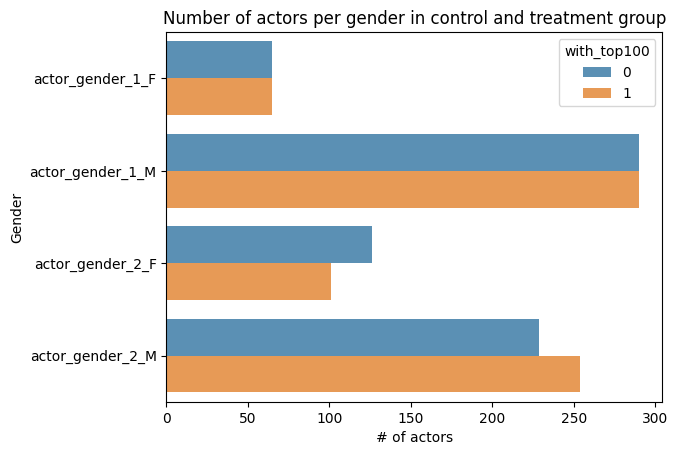

In [176]:
# Sanity check for gender exact matching
# matched_gender = pd.get_dummies(matched_actor_feats, columns=['actor_gender_1','actor_gender_2'])
# matched_gender = matched_gender[['with_top100']+[col for col in matched_gender.columns if 'gender' in col]].groupby('with_top100', as_index=False).sum()
matched_gender = matched_actor_feats[['with_top100']+[col for col in matched_actor_feats.columns if 'gender' in col]].groupby('with_top100', as_index=False).sum()
matched_gender = matched_gender.melt(id_vars='with_top100', value_name='count')

sns.barplot(x='count', y='variable', hue='with_top100', data=matched_gender, alpha=0.8)
plt.ylabel('Gender')
plt.xlabel('# of actors')
plt.title('Number of actors per gender in control and treatment group');

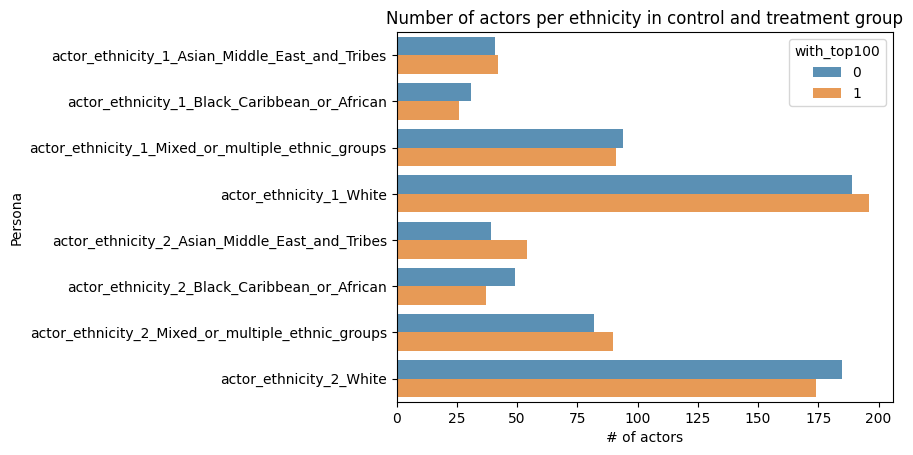

In [177]:
# Sanity check for ethnicity exact matching
# matched_ethnicity = pd.get_dummies(matched_actor_feats, columns=['actor_ethnicity_1','actor_ethnicity_2'])
# matched_ethnicity = matched_ethnicity[['with_top100']+[col for col in matched_ethnicity.columns if 'ethnicity' in col]].groupby('with_top100', as_index=False).sum()
matched_ethnicity = matched_actor_feats[['with_top100']+[col for col in matched_actor_feats.columns if 'ethnicity' in col]].groupby('with_top100', as_index=False).sum()
matched_ethnicity = matched_ethnicity.melt(id_vars='with_top100', value_name='count')

sns.barplot(x='count', y='variable', hue='with_top100', data=matched_ethnicity, alpha=0.8)
plt.ylabel('Persona')
plt.xlabel('# of actors')
plt.title('Number of actors per ethnicity in control and treatment group');


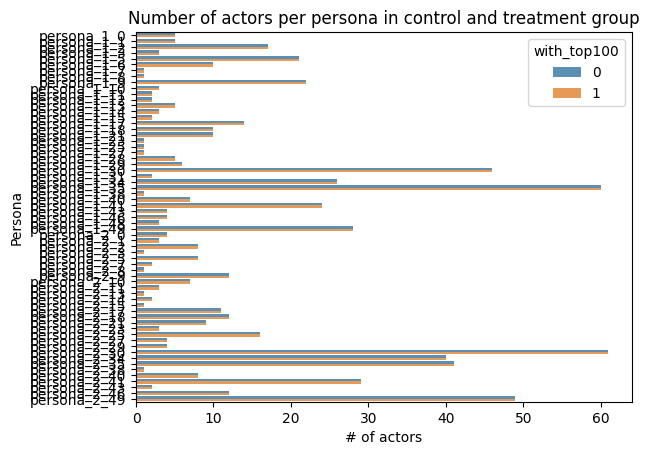

In [178]:
# Sanity check for persona exact matching
matched_persona = pd.get_dummies(matched_actor_feats, columns=['persona_1','persona_2'])
matched_persona = matched_persona[['with_top100']+[col for col in matched_persona.columns if 'persona' in col]].groupby('with_top100', as_index=False).sum()
matched_persona = matched_persona.melt(id_vars='with_top100', value_name='count')

sns.barplot(x='count', y='variable', hue='with_top100', data=matched_persona, alpha=0.8)
plt.ylabel('Persona')
plt.xlabel('# of actors')
plt.title('Number of actors per persona in control and treatment group');

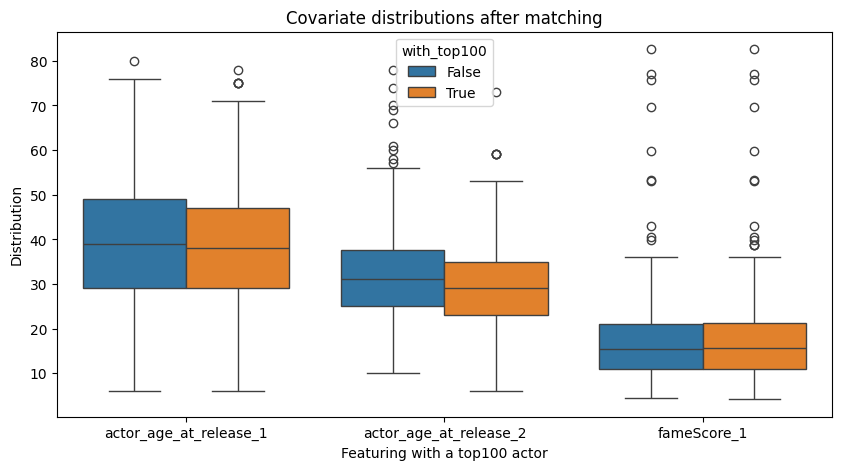

In [179]:
# Sanity check for age at film release for both actors and fameScrore for benefitting actor
matched_actor_feats['actor_age_at_release_1']=matched_actor_feats['actor_age_at_release_1'].astype(int)
matched_actor_feats['actor_age_at_release_2']=matched_actor_feats['actor_age_at_release_2'].astype(int)
matched_actor_feats['with_top100']=matched_actor_feats['with_top100'].astype(bool)

plt.figure(figsize=(10,5))
sns.boxplot(data=matched_actor_feats[['actor_age_at_release_1','actor_age_at_release_2','fameScore_1','with_top100']]\
                    .melt(value_vars=['actor_age_at_release_1','actor_age_at_release_2','fameScore_1'],
                          id_vars='with_top100'),
            y='value',
            x='variable',
            hue='with_top100')
plt.title('Covariate distributions after matching')
plt.ylabel('Distribution')
plt.xlabel('Featuring with a top100 actor');

Both groups have similar distributions over observed covariates, therefore we may now under the naive model consider that any observable effect is not due to an observable confounder.

In [180]:
avg_fameScore_diff = matched_actor_feats.groupby('with_top100',as_index=False)[['fameScore_diff']]\
                                        .agg(avg=('fameScore_diff','mean'), 
                                             ci=('fameScore_diff',lambda x:1.96*stats.sem(x)))

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=avg_fameScore_diff['with_top100'],
    y=avg_fameScore_diff['avg'],
    mode='markers',
    error_y=dict(
        type='data', 
        array=avg_fameScore_diff['ci'],
        visible=True,
        thickness=2.5,
        width=30,
        color='cornflowerblue'
    ),
    marker=dict(
        color='cornflowerblue'
    )
    ))

fig.update_layout(xaxis_title='Featuring with a top100 actor', 
                  yaxis_title='Fame score difference before/after a film', 
                  title='Impact on fame score of featuring with a famous actor in a movie',
                  height=500, 
                  width=600)
fig.update_xaxes(range=[-1, 2])
fig.show()

In [181]:
stats.ttest_ind(matched_actor_feats.query('with_top100==1')['fameScore_diff'].values, 
                matched_actor_feats.query('with_top100==0')['fameScore_diff'].values)

TtestResult(statistic=3.7877916057923637, pvalue=0.00016490274268631078, df=708.0)

It appears from the pointplot that the treated group has a higher fame increase afetr featuring with a famous actor compared to actors who do not make such feats. This is verified with a t-test where the p-value allows us to reject the null hypothesis at the 0.05 level.

### 2.3 Network Analysis

The previously studied feats between actors may now be seen from another point of view. Indeed, we may look at feats as links between a network of actors.

In [182]:
# Helper function for plotting the degree distribution of a Graph
def plot_degree_distribution(G):
    degrees = {}
    for node in G.nodes():
        degree = G.degree(node)
        if degree not in degrees:
            degrees[degree] = 0
        degrees[degree] += 1
    sorted_degree = sorted(degrees.items())
    deg = [k for (k,v) in sorted_degree]
    cnt = [v for (k,v) in sorted_degree]
    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')
    plt.title("Degree Distribution")
    plt.ylabel("Frequency")
    plt.xlabel("Degree")
    ax.set_xticks([d+0.05 for d in deg])
    ax.set_xticklabels(deg)

# Helper function for printing various graph properties
def describe_graph(G):
    print(G)
    if nx.is_connected(G):
        print("Graph is connected")
        print("Avg. Shortest Path Length: %.4f" %nx.average_shortest_path_length(G))
        print("Diameter: %.4f" %nx.diameter(G)) # Longest shortest path
    else:
        print("Graph is not connected")
        print("Diameter and Avg shortest path length are not defined!")
    print("Sparsity: %.4f" %nx.density(G))  # #edges/#edges-complete-graph
    # #closed-triplets(3*#triangles)/#all-triplets
    print("Global clustering coefficient aka Transitivity: %.4f" %nx.transitivity(G))

# Helper function for visualizing the graph
def visualize_graph(G, with_labels=True, k=None, alpha=1.0, node_shape='o'):
    #nx.draw_spring(G, with_labels=with_labels, alpha = alpha)
    pos = nx.spring_layout(G, k=k)
    if with_labels:
        lab = nx.draw_networkx_labels(G, pos, labels=dict([(n, n) for n in G.nodes()]))
    ec = nx.draw_networkx_edges(G, pos, alpha=alpha)
    nc = nx.draw_networkx_nodes(G, pos, nodelist=G.nodes(), node_color='g', node_shape=node_shape)
    plt.axis('off')

In [183]:
# create a graph of actors connected by films made together. The graph time dependence is here not considered.
G = nx.from_pandas_edgelist(matching_data, 'freebase_actorID_1', 'freebase_actorID_2')
describe_graph(G)

Graph with 1838 nodes and 8694 edges
Graph is not connected
Diameter and Avg shortest path length are not defined!
Sparsity: 0.0051
Global clustering coefficient aka Transitivity: 0.1386


The graph is not connected however we are more interested in having connected components so that all kind of metrics can be computed. First, we isolate the main component in the graph by plotting the node size of each component.

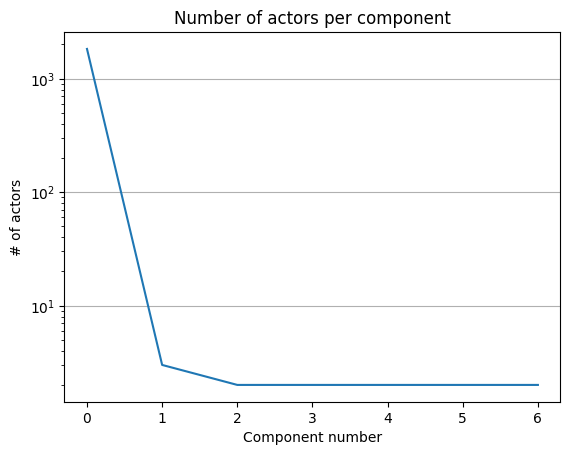

In [184]:
components = list(nx.connected_components(G)) # cut graph into N connected components
components = sorted(components, key=len) # sort then of size
components.reverse()
components_number = {n:np.argmax([n in c for c in components]) for n in G.nodes()} # assign number to each component
nx.set_node_attributes(G, components_number, 'comp')

plt.plot([len(c) for c in components])
plt.title('Number of actors per component')
plt.ylabel('# of actors')
plt.xlabel('Component number')
plt.yscale('log')
plt.grid(axis='y')

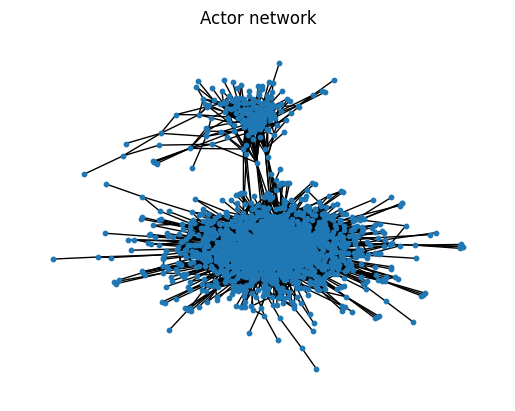

In [185]:
# get subgraph of G containing main component. Very few nodes are lost actuallly
G = nx.subgraph(G, components[0])

pos = nx.spring_layout(G, seed=0)
nx.draw_networkx_nodes(G, pos=pos, node_size=10)
nx.draw_networkx_edges(G, pos=pos);
plt.axis('off')
plt.title('Actor network');

The network appears to be splitted in two main groups. Let's recall that our dataset provides films from all over the world in many different languages. It would hence make sense to observe some clusters of actors with many connections as they play in a certain country cinema industry. Our first guess is that the main cluster corresponds to Hollywood actors while the smaller one is Bollywood. It is to note that some weak ties link these two worlds, probably being actors who portrayed is films in both Hollywood and Bollywood, hence having connections in both. Let's confirm or not the validity of this hypothesis.


In [186]:
def get_main_language(df):
    '''
    This function returns the language with the most occurences
    in an actor filmography given as input.
    '''
    lst=np.hstack(df['language']).tolist()
    if lst==[]:
        return 'NoLanguage'
    return max(lst, key=lst.count)

# get the language with most occurences for each actor
actor_language = cmu_character.merge(cmu_movies[['wikiID','language']]).groupby('freebase_actorID').apply(get_main_language).to_dict()
# creates mapping from language to number (used for plots)
language_num_dict = {l:n for l,n in zip(actor_language.values(), range(len(actor_language)))}

# add the language attribute to actor nodes
nx.set_node_attributes(G, {n:actor_language[n] for n in G.nodes()}, 'language')

/Users/killianhd/anaconda3/envs/ada/lib/python3.9/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.



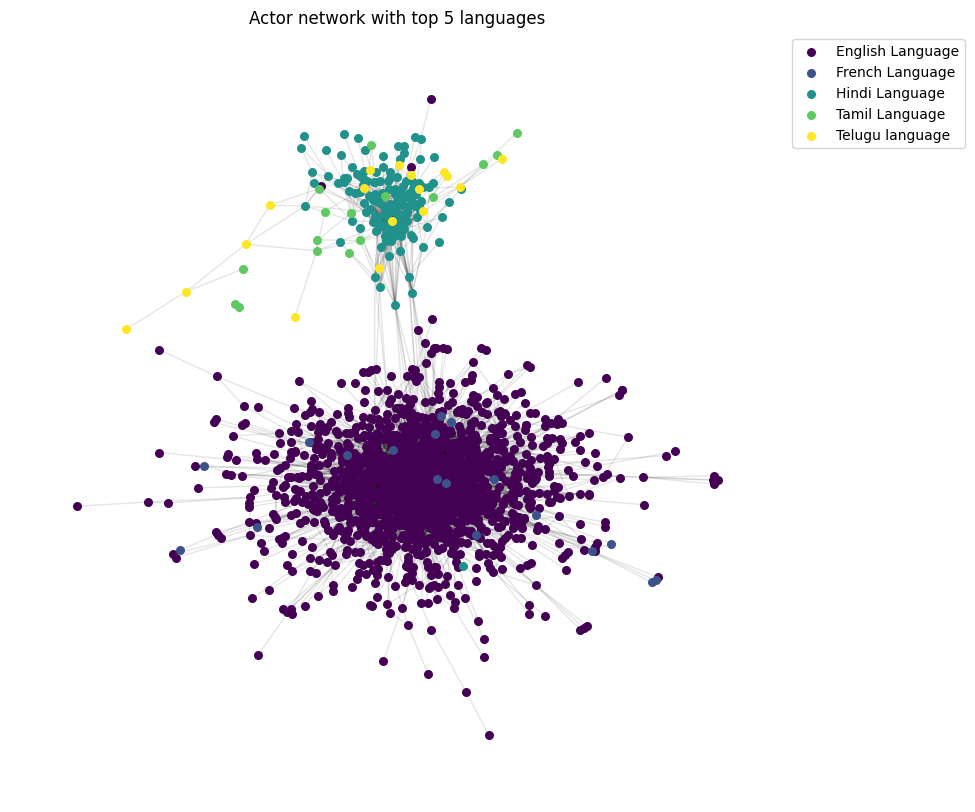

In [187]:
# keep only languages with more than 10 actors otherwise too many similar color with viridis color map
languages, counts = np.unique([G.nodes()[n]['language'] for n in G.nodes()], return_counts=True)
languages = languages[counts > 10]

# define color map and sample 6 colors
cmap = plt.colormaps["viridis"].resampled(len(languages))
colors = cmap.colors.tolist()


plt.figure(figsize=(10,10))
nx.draw_networkx_edges(G, pos=pos,alpha=0.1, edgelist=[e for e in G.edges() if G.nodes()[e[0]]['language'] in languages and G.nodes()[e[1]]['language'] in languages])

for i,language in enumerate(languages):
    # isolate subgraph of actors with 'language' as most occuring language
    subG = nx.subgraph(G, [n for n in G.nodes() if G.nodes()[n]['language']==language])
    # get their positions in orignal spring_layout
    subpos = {n:p for n,p in pos.items() if G.nodes()[n]['language']==language}
    nx.draw_networkx_nodes(subG,
                           pos=subpos,
                           node_size=30,
                           node_color=colors[i],
                           label=language,
                           alpha=1)

plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.axis('off');
plt.title('Actor network with top 5 languages');

Our initial hypothesis is verified as the main group of actors only features English and French speaking actors. On the other hand the smaller cluster comprises actors speaking Hindi, Tamil and Telugu which can be attributed to Bollywood.

In future analysis, we would like to study the links between network centrality using the betweenness, Katz and closeness centrality metrics. However, we face an issue because of the nature of the network. Indeed, actors with high betweenness centrality would be those linking Bollywood and Hollywood but there are no guarantees for their fame. Let's first confirm this by computing the betweenness centrality of all nodes with both Hollywood and Bollywood.

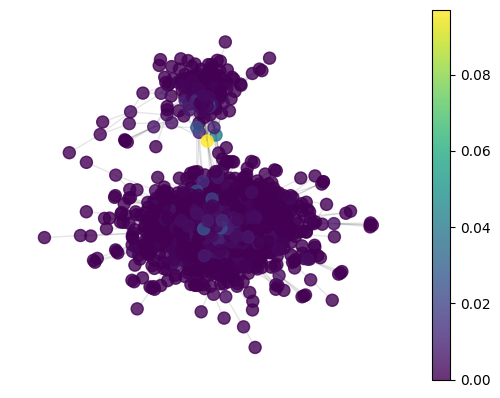

In [188]:
# Compute betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)
# Assign the computed centrality values as a node-attribute in your network
nx.set_node_attributes(G, betweenness_centrality, 'betweenness')

list_nodes =list(G.nodes())
list_nodes.reverse()   # for showing the nodes with high betweeness centrality 
ec = nx.draw_networkx_edges(G, pos, alpha=0.1)
nc = nx.draw_networkx_nodes(G, pos, nodelist=list_nodes, node_color=[G.nodes[n]["betweenness"] for n in list_nodes], 
                            alpha=0.8, node_shape = '.')
plt.colorbar(nc)
plt.axis('off')
plt.show()

Our concerns are confirmed as high centrality is characterized by actors linking Hollywood and Bollywood. We will hence restrict our analysis to English speaking actors in the subsequent cells, namely Hollywood.

In [189]:
# get subgraph of English speaking actors
G = nx.subgraph(G, [n for n in G.nodes() if 'English' in G.nodes()[n]['language']])

# get main connected component among Englih speaking actors
components = list(nx.connected_components(G)) 
components = sorted(components, key=len)
components.reverse()
G = nx.subgraph(G, components[0])

print(G)

Graph with 1585 nodes and 7791 edges


Let's now compute betweenness, Katz and closeness centrality for Hollywood actors.

In [190]:
# Compute betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)
# Assign the computed centrality values as a node-attribute in your network
nx.set_node_attributes(G, betweenness_centrality, 'betweenness_centrality')

betweenness = pd.DataFrame({'freebase_actorID':betweenness_centrality.keys(), 'betweenness_centrality':betweenness_centrality.values()})
# merge with cmu_character to get actor names
betweenness.merge(cmu_character[['freebase_actorID','actor_name']])\
           .drop_duplicates()\
           .sort_values('betweenness_centrality',ascending=False)\
           .head(10)

,freebase_actorID,betweenness_centrality,actor_name
6249,/m/06cgy,0.035956,Robert De Niro
887,/m/055c8,0.026638,Morgan Freeman
7102,/m/016fjj,0.025000,Christopher Walken
10298,/m/0f5xn,0.023551,Samuel L. Jackson
10030,/m/0h5g_,0.023317,Liam Neeson
7584,/m/02lymt,0.023147,Wesley Snipes
8143,/m/04yj5z,0.021116,John Leguizamo
297,/m/0171cm,0.020059,Tom Wilkinson
9457,/m/0lkr7,0.019262,Nick Nolte
22203,/m/0gn30,0.017615,Sylvester Stallone


In [191]:
# use max(nx.adjacency_spectrum(G)) as algorithm converges for alpha < 1/max(adjacency_eigen_values)
katz_centrality = nx.katz_centrality(G, alpha=0.9/max(abs(nx.adjacency_spectrum(G))))
# Assign the computed centrality values as a node-attribute in your network
nx.set_node_attributes(G, katz_centrality, 'katz_centrality')

katz = pd.DataFrame({'freebase_actorID':katz_centrality.keys(), 'katz_centrality':katz_centrality.values()})
# merge with cmu_character to get actor names
katz.merge(cmu_character[['freebase_actorID','actor_name']])\
    .drop_duplicates()\
    .sort_values('katz_centrality',ascending=False)\
    .head(10)

,freebase_actorID,katz_centrality,actor_name
887,/m/055c8,0.130260,Morgan Freeman
6249,/m/06cgy,0.125525,Robert De Niro
8143,/m/04yj5z,0.103413,John Leguizamo
6147,/m/0169dl,0.103326,Matt Damon
5534,/m/046zh,0.102003,Julia Roberts
7102,/m/016fjj,0.101125,Christopher Walken
10030,/m/0h5g_,0.099661,Liam Neeson
12111,/m/0mdqp,0.094230,Ben Stiller
15895,/m/0205dx,0.090376,Danny Glover
1473,/m/014gf8,0.089513,Laurence Fishburne


In [192]:
closeness_centrality = nx.closeness_centrality(G)
# Assign the computed centrality values as a node-attribute in your network
nx.set_node_attributes(G, closeness_centrality, 'closeness_centrality')

closeness = pd.DataFrame({'freebase_actorID':closeness_centrality.keys(), 'closeness_centrality':closeness_centrality.values()})
# merge with cmu_character to get actor names
closeness.merge(cmu_character[['freebase_actorID','actor_name']])\
         .drop_duplicates()\
         .sort_values('closeness_centrality',ascending=False)\
         .head(10)

,freebase_actorID,closeness_centrality,actor_name
6249,/m/06cgy,0.386624,Robert De Niro
887,/m/055c8,0.384000,Morgan Freeman
7102,/m/016fjj,0.378947,Christopher Walken
8143,/m/04yj5z,0.376068,John Leguizamo
5534,/m/046zh,0.371831,Julia Roberts
15895,/m/0205dx,0.368544,Danny Glover
1473,/m/014gf8,0.366582,Laurence Fishburne
10030,/m/0h5g_,0.366243,Liam Neeson
4998,/m/07r1h,0.365651,Tom Cruise
12111,/m/0mdqp,0.365567,Ben Stiller


In [196]:
partition = community_louvain.best_partition(G, random_state=0)
# add it as an attribute to the nodes
for n in G.nodes:
    G.nodes[n]["louvain"] = partition[n]

number_communities = len(np.unique(list(partition.values())))
number_communities

18

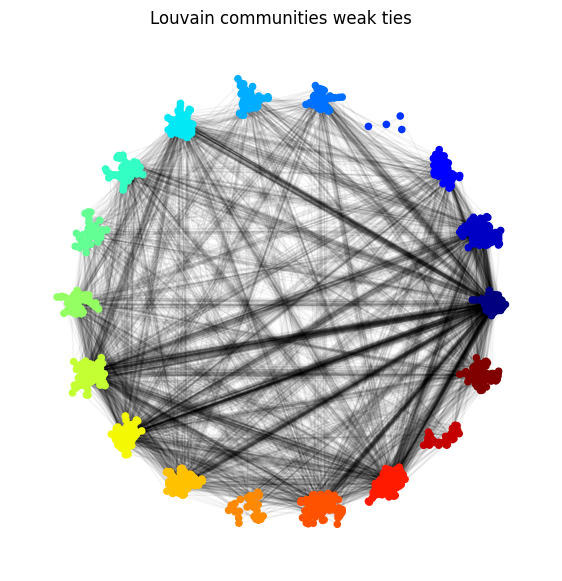

In [197]:
cmap = plt.colormaps["viridis"].resampled(number_communities)
colors = cmap.colors.tolist()

circle_G = nx.Graph()
circle_G.add_nodes_from(np.arange(number_communities))
circle_pos = {k:10*v for k,v in nx.circular_layout(circle_G).items()}

pos_coms = {}
for com in range(number_communities):
    G_com = nx.subgraph(G, [n for n in G.nodes() if G.nodes()[n]['louvain']==com])
    pos_coms.update({k:v+circle_pos[com] for k,v in nx.spring_layout(G_com).items()})

plt.figure(figsize=(7,7))
nx.draw_networkx_edges(G, pos=pos_coms, alpha=0.05)
nx.draw_networkx_nodes(G, pos=pos_coms, node_color=[G.nodes[n]["louvain"] for n in G.nodes()], node_size=20,cmap=plt.cm.jet)
plt.title('Louvain communities weak ties')
plt.axis('off');

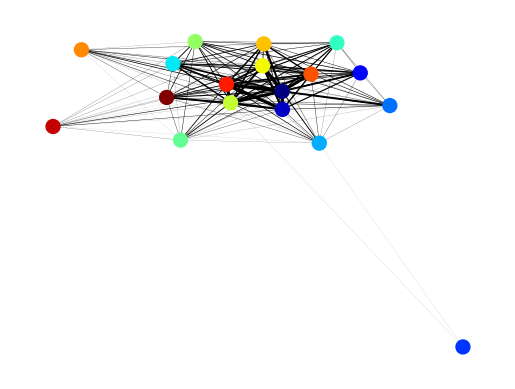

In [198]:
weak_ties = pd.DataFrame([[e[0], G.nodes()[e[0]]['louvain'], e[1], G.nodes()[e[1]]['louvain']] for e in G.edges() if G.nodes()[e[0]]['louvain']!=G.nodes()[e[1]]['louvain']],
                     columns=['node_1','louvain_1','node_2','louvain_2'])

edges_com = weak_ties.groupby(['louvain_1','louvain_2']).agg(weight=('node_1','count'))

G_com = nx.from_pandas_edgelist(edges_com.reset_index(),'louvain_1','louvain_2','weight')

pos_com = nx.spring_layout(G_com, seed=15)
nx.draw_networkx_edges(G_com, pos=pos_com, alpha=1, width=[G_com.edges()[e]['weight']/25 for e in G_com.edges()])
nx.draw_networkx_nodes(G_com, pos=pos_com, node_color=range(number_communities), node_size=100,cmap=plt.cm.jet)
plt.axis('off');

Most communities have fery few links between them, however there is a small group of communities strongly connected. This shows that the Louvain algorithm manages quite well to isolate cuts of the graph forming a cluster. For example, by looking specifically at the cast for the saga Harry Potter, we observe that actors playing Harry Potter, Hermione Granger, Minerva McGonagall, Severus Snape, etc are all in community 0. This actually makes quite a lot of sense as they all played in the saga together hence have all edges between them forming a cluster. Now, we may be interrested by whether a community is more famous than another, or if one community has higher fame increases.

In [199]:
# define actor_louvain populating the louvain partition with actors' fame data
actor_louvain = cmu_character.merge(pd.DataFrame({'freebase_actorID':partition.keys(),
                                                  'louvain':partition.values()}))
actor_louvain.query("louvain==0")[['actor_name','fameScore']].sort_values('fameScore', ascending=False).drop_duplicates(subset='actor_name').actor_name.values

array(['Alan Rickman', 'Catherine McCormack', 'Mackenzie Crook',
       'Orlando Bloom', 'Damian Lewis', 'Dustin Hoffman', 'Max Martini',
       'Peter Mullan', 'Nick Frost', 'Ashley Jensen', 'Caterina Murino',
       'Jennifer Connelly', 'Katie Leung', 'Quentin Tarantino',
       'Sam Elliott', 'Johnny Depp', 'Martine McCutcheon',
       'Ioan Gruffudd', 'Tom Hardy', 'Gael García Bernal',
       'Naomie Harris', 'Ellen Pompeo', 'Shirley Henderson',
       'Emma Watson', 'Thomas McCarthy', 'Bahar Soomekh', 'Uma Thurman',
       'Alison Lohman', 'Eva Green', 'Anthony Mackie', 'Kristanna Loken',
       'Monica Bellucci', 'James Cosmo', 'Edgar Ramirez',
       'Kelly Macdonald', 'Nicholas Hoult', 'Daniel Radcliffe',
       'Bonnie Wright', 'Paul Giamatti', 'Martin Freeman', 'Burt Young',
       'Imogen Poots', 'Guy Pearce', 'Mischa Barton', 'Leonardo DiCaprio',
       'Harvey Keitel', 'Michael Peter Balzary', 'Julia Sawalha',
       'Paul McGann', 'Angela Lansbury', 'Jake Gyllenhaal', 'Ja

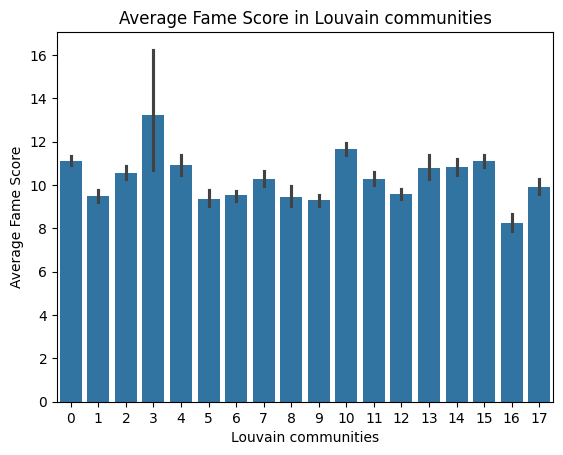

In [200]:
sns.barplot(data=actor_louvain, x='louvain',y='fameScore')
plt.xlabel('Louvain communities')
plt.ylabel('Average Fame Score')
plt.title('Average Fame Score in Louvain communities');

In [201]:
fig = px.bar(actor_louvain.groupby('louvain', as_index=False).agg(avg=('fameScore','mean'), ci=('fameScore',lambda x : 1.96*stats.sem(x))),
             x='louvain', 
             y='avg', 
             error_y='ci', 
             labels={'louvain': 'Louvain communities', 'fameScore': 'Average Fame Score'},
             title='Average Fame Score in Louvain communities')

fig.update_layout(xaxis_title='Louvain communities', yaxis_title='Average Fame Score', height=500, width=700)

fig.show()

In [202]:
# Compute the p-value that average fame for each community has equal mean
samples=[]
for i in range(number_communities):
    samples += [actor_louvain.query(f'louvain=={i}').fameScore.values]

stats.f_oneway(*samples)

F_onewayResult(statistic=26.92127984562564, pvalue=6.34995161713091e-86)

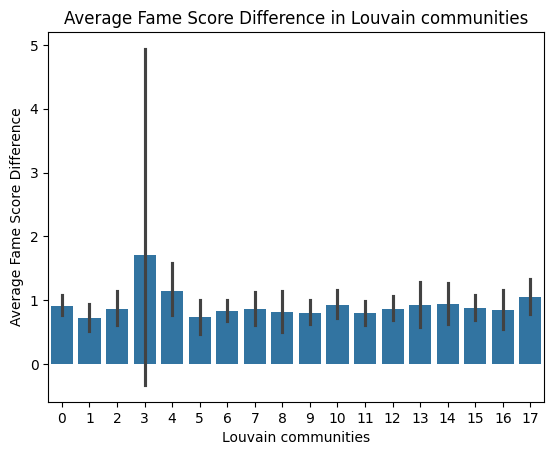

In [203]:
actor_louvain['fameScore_diff']=actor_louvain['fameScore']-actor_louvain['fameScore_before']

sns.barplot(data=actor_louvain, x='louvain',y='fameScore_diff')
plt.xlabel('Louvain communities')
plt.ylabel('Average Fame Score Difference')
plt.title('Average Fame Score Difference in Louvain communities');

In [204]:
fig = px.bar(actor_louvain.groupby('louvain', as_index=False).agg(avg=('fameScore_diff','mean'), ci=('fameScore_diff',lambda x : 1.96*stats.sem(x))),
             x='louvain', 
             y='avg', 
             error_y='ci', 
             labels={'louvain': 'Louvain communities', 'fameScore_diff': 'Average Fame Score Difference'},
             title='Average Fame Score in Louvain communities')

fig.update_layout(xaxis_title='Louvain communities', yaxis_title='Average Fame Score Difference', height=500, width=700)

fig.show()

In [205]:
# Compute the p-value that average fame difference for each community has equal mean
samples=[]
for i in range(number_communities):
    samples += [actor_louvain.query(f'louvain=={i}').fameScore_diff.values]

stats.f_oneway(*samples)

F_onewayResult(statistic=0.6963423818287546, pvalue=0.8098241705227386)

According to ANOVA hypothesis testing, the null hypothesys stating that the communities have fames and fame increases with the same mean accross communities can be rejected. Actors should hence aim at joining certain communities, especially community 19 so as to have a high fame score and community 5,10 or 19 for lesser known actor willing to get fame increases.

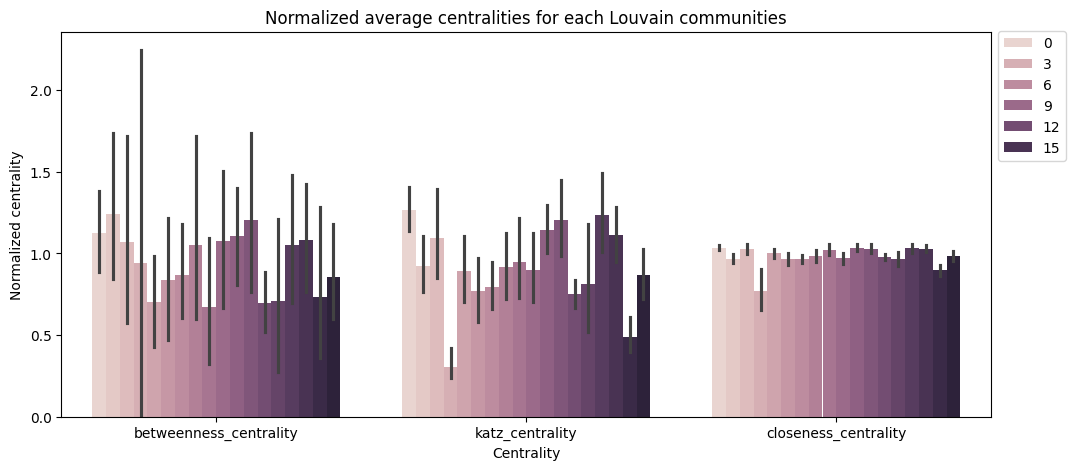

In [206]:
# is there a community more central than others

centralities = pd.DataFrame({'freebase_actorID':partition.keys(),'louvain':partition.values()})\
                            .merge(betweenness, on='freebase_actorID')\
                            .merge(katz, on='freebase_actorID')\
                            .merge(closeness, on='freebase_actorID')
normalized_centralities = centralities.copy()
normalized_centralities[['betweenness_centrality','katz_centrality','closeness_centrality']] /=\
      np.mean(normalized_centralities[['betweenness_centrality','katz_centrality','closeness_centrality']], axis=0)

plt.figure(figsize=(12,5))
sns.barplot(normalized_centralities.melt(id_vars='louvain',
                                         value_vars=['betweenness_centrality','katz_centrality','closeness_centrality'],
                                         value_name='Normalized centrality',
                                         var_name='Centrality'),
            y='Normalized centrality',
            hue='louvain',
            x='Centrality')

plt.title('Normalized average centralities for each Louvain communities')
plt.legend(loc='upper left', bbox_to_anchor=(1,1.02));

In [207]:
louvain_centralities = centralities.drop('freebase_actorID',axis=1)\
                                   .melt(id_vars='louvain',
                                         value_vars=['betweenness_centrality', 'katz_centrality', 'closeness_centrality'],
                                         value_name='value',
                                         var_name='centrality')\
                                   .groupby(['louvain','centrality'], as_index=False)\
                                   .agg(avg=('value','mean'), ci=('value',lambda x : 1.96*stats.sem(x)))

fig = px.bar(louvain_centralities.query("centrality=='betweenness_centrality'"),
             x='louvain', 
             y='avg', 
             error_y='ci', 
             labels={'louvain': 'Louvain communities', 'avg': 'Average centrality'},
             title='Average betweenness centrality in Louvain communities')

fig.update_layout(xaxis_title='Louvain communities', yaxis_title='Average betweenness centrality', height=500, width=700)

fig.show()

In [208]:
fig = px.bar(louvain_centralities.query("centrality=='katz_centrality'"),
             x='louvain', 
             y='avg', 
             error_y='ci', 
             labels={'louvain': 'Louvain communities', 'avg': 'Average centrality'},
             title='Average katz centrality in Louvain communities')

fig.update_layout(xaxis_title='Louvain communities', yaxis_title='Average katz centrality', height=500, width=700)

fig.show()

In [209]:
fig = px.bar(louvain_centralities.query("centrality=='closeness_centrality'"),
             x='louvain', 
             y='avg', 
             error_y='ci', 
             labels={'louvain': 'Louvain communities', 'avg': 'Average centrality'},
             title='Average closeness centrality in Louvain communities')

fig.update_layout(xaxis_title='Louvain communities', yaxis_title='Average closeness centrality', height=500, width=700)

fig.show()

In [210]:
for centrality in centralities.columns[-3:]:
    samples=[]
    for i in range(number_communities):
        samples += [centralities.query(f"louvain=={i}")[centrality].values]

    f,pvalue = stats.f_oneway(*samples)
    print(f'{centrality} : (f : {f}, p-value : {pvalue})')

betweenness_centrality : (f : 0.8392022240993133, p-value : 0.6479245865844904)
katz_centrality : (f : 4.553857871221615, p-value : 2.0119040658823786e-09)
closeness_centrality : (f : 7.076969614636068, p-value : 7.24884614819209e-17)


Some communities clearly are more central than others, actors should aim at joining the most central ones if central equivalent to famous

In [211]:
matching_data = matching_data.merge(centralities, left_on='freebase_actorID_1', right_on='freebase_actorID').drop(columns='freebase_actorID')
matching_data.columns = list(matching_data.columns[:-4])+[col+'_1' for col in matching_data.columns[-4:]]
matching_data = matching_data.merge(centralities, left_on='freebase_actorID_2', right_on='freebase_actorID').drop(columns='freebase_actorID')
matching_data.columns = list(matching_data.columns[:-4])+[col+'_2' for col in matching_data.columns[-4:]]
matching_data.head()

,wikiID,actor_height_1,actor_age_at_release_1,freebase_actorID_1,fameScore_1,persona_1,release_date,fameScore_diff,actor_height_2,actor_age_at_release_2,...,actor_ethnicity_2_White,propensity,louvain_1,betweenness_centrality_1,katz_centrality_1,closeness_centrality_1,louvain_2,betweenness_centrality_2,katz_centrality_2,closeness_centrality_2
0,3493076,1.85,37.0,/m/010xjr,10.399746,27,1967-10-25,-0.049722,1.8,30.0,...,True,0.015629,0,0.004219,0.032671,0.315978,0,0.002172,0.031191,0.321363
1,133622,1.71,32.0,/m/0159h6,11.549927,49,1992-03-13,1.178118,1.8,55.0,...,True,0.001623,0,0.005077,0.050423,0.332354,0,0.002172,0.031191,0.321363
2,1566225,1.73,25.0,/m/01g25r,16.324003,49,2000-03-05,-1.293630,1.8,63.0,...,True,0.001073,0,0.001439,0.019639,0.306680,0,0.002172,0.031191,0.321363
3,25698427,1.68,31.0,/m/037kr_,13.478272,49,2010-04-25,0.683650,1.8,73.0,...,True,0.000978,0,0.000028,0.007864,0.267522,0,0.002172,0.031191,0.321363
4,25698427,1.61,24.0,/m/03zz8b,15.207829,49,2010-04-25,0.400015,1.8,73.0,...,True,0.000647,0,0.001756,0.026266,0.314161,0,0.002172,0.031191,0.321363


In [212]:
matching_data['treatment'] = (matching_data['louvain_1']==matching_data['louvain_2']).astype(int)

formula = 'treatment ~ actor_height_1 + actor_age_at_release_1 + fameScore_1 + actor_height_2 + actor_age_at_release_2 + fameScore_2'

for col in matching_data.columns:
    if 'gender' in col or 'ethnicity' in col:
        formula += ' + C('+col+')'

mod = smf.logit(formula=formula, data=matching_data)
res = mod.fit()
print(res.summary())

matching_data['propensity']=res.predict()

         Current function value: 0.685272
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:              treatment   No. Observations:                14222
Model:                          Logit   Df Residuals:                    14203
Method:                           MLE   Df Model:                           18
Date:                Fri, 22 Dec 2023   Pseudo R-squ.:                 0.01056
Time:                        03:51:20   Log-Likelihood:                -9745.9
converged:                      False   LL-Null:                       -9850.0
Covariance Type:            nonrobust   LLR p-value:                 2.430e-34
                                                                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------
Intercept                                   

/Users/killianhd/anaconda3/envs/ada/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [213]:
control=matching_data.query('treatment==0')
treated=matching_data.query('treatment==1')

G=nx.Graph()

centrality_tol=0.3
for treated_id, treated_data in tqdm(treated.iterrows()):
        # exact matching on persona played
        c = control[np.all(control[['persona_1','persona_2','with_top100']]==\
                           treated_data[['persona_1','persona_2','with_top100']], axis=1)]

        # force centrality to vary by a tolerance maximum, mostly useful to reduce number of nodes in max_weight_matching
        c = c[(np.abs((c['betweenness_centrality_1']-treated_data['betweenness_centrality_1'])/treated_data['betweenness_centrality_1']))<=centrality_tol]
        c = c[(np.abs((c['betweenness_centrality_2']-treated_data['betweenness_centrality_1'])/treated_data['betweenness_centrality_1']))<=centrality_tol]
        c = c[(np.abs((c['katz_centrality_1']-treated_data['katz_centrality_1'])/treated_data['katz_centrality_1']))<=centrality_tol]
        c = c[(np.abs((c['katz_centrality_2']-treated_data['katz_centrality_2'])/treated_data['katz_centrality_2']))<=centrality_tol]
        c = c[(np.abs((c['closeness_centrality_1']-treated_data['closeness_centrality_1'])/treated_data['closeness_centrality_1']))<=centrality_tol]
        c = c[(np.abs((c['closeness_centrality_2']-treated_data['closeness_centrality_2'])/treated_data['closeness_centrality_2']))<=centrality_tol]
        
        similarity_ = list(map(lambda p1: similarity(p1,treated_data['propensity']), c['propensity']))
        
        edges = list(map(lambda x,y : [x, treated_id, y], c.index, similarity_))

        G.add_weighted_edges_from(edges)
        
print(G)
matching = nx.max_weight_matching(G)
print('Number of matches :',len(matching))

6873it [00:17, 394.92it/s]


Graph with 1057 nodes and 1275 edges
Number of matches : 385


In [214]:
# retrieve matched feats
matched_actor_feats=matching_data.loc[[n[0] for n in matching] + [n[1] for n in matching]]
matched_actor_feats.sample(5)

,wikiID,actor_height_1,actor_age_at_release_1,freebase_actorID_1,fameScore_1,persona_1,release_date,fameScore_diff,actor_height_2,actor_age_at_release_2,...,propensity,louvain_1,betweenness_centrality_1,katz_centrality_1,closeness_centrality_1,louvain_2,betweenness_centrality_2,katz_centrality_2,closeness_centrality_2,treatment
6849,23829273,1.780,42.0,/m/01wmxfs,13.817189,28,2010-10-31,1.135341,1.75,45.0,...,0.558778,17,0.003514,0.028316,0.318969,7,0.003629,0.044421,0.341453,0
7618,3032361,1.800,37.0,/m/01q_ph,19.127628,46,2006-07-13,-0.033220,1.68,27.0,...,0.503474,10,0.007295,0.067626,0.350598,15,0.004747,0.037133,0.328290,0
10251,28150124,1.797,29.0,/m/05txrz,26.720394,49,2011-09-12,0.919776,1.78,30.0,...,0.475627,10,0.004474,0.049476,0.340426,0,0.005264,0.044837,0.337237,0
2757,1162528,1.820,31.0,/m/01r93l,21.576578,49,2004-12-03,1.085778,1.75,37.0,...,0.503707,11,0.009198,0.079953,0.357320,11,0.014046,0.102003,0.371831,1
6237,1774803,1.630,31.0,/m/01c_zw,11.693773,49,2001-04-04,1.407084,1.87,40.0,...,0.474347,14,0.008048,0.067783,0.352157,0,0.007896,0.066158,0.346988,0


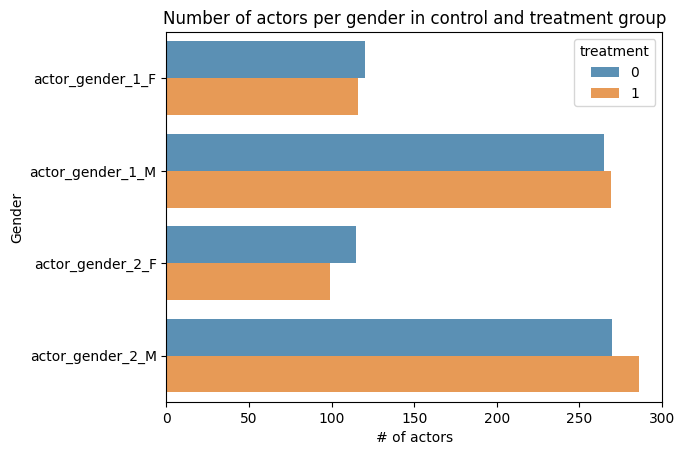

In [215]:
# Sanity check for gender exact matching
# matched_gender = pd.get_dummies(matched_actor_feats, columns=['actor_gender_1','actor_gender_2'])
# matched_gender = matched_gender[['treatment']+[col for col in matched_gender.columns if 'gender' in col]].groupby('treatment', as_index=False).sum()
matched_gender = matched_actor_feats[['treatment']+[col for col in matched_actor_feats.columns if 'gender' in col]].groupby('treatment', as_index=False).sum()
matched_gender = matched_gender.melt(id_vars='treatment', value_name='count')

sns.barplot(x='count', y='variable', hue='treatment', data=matched_gender, alpha=0.8)
plt.ylabel('Gender')
plt.xlabel('# of actors')
plt.title('Number of actors per gender in control and treatment group');

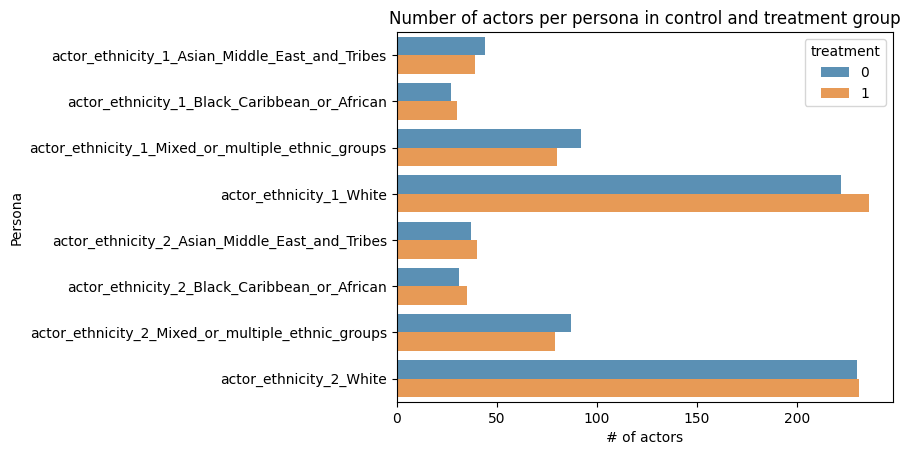

In [216]:
# Sanity check for ethnicity exact matching
# matched_ethnicity = pd.get_dummies(matched_actor_feats, columns=['actor_ethnicity_1','actor_ethnicity_2'])
# matched_ethnicity = matched_ethnicity[['treatment']+[col for col in matched_ethnicity.columns if 'ethnicity' in col]].groupby('treatment', as_index=False).sum()
matched_ethnicity = matched_actor_feats[['treatment']+[col for col in matched_actor_feats.columns if 'ethnicity' in col]].groupby('treatment', as_index=False).sum()
matched_ethnicity = matched_ethnicity.melt(id_vars='treatment', value_name='count')

sns.barplot(x='count', y='variable', hue='treatment', data=matched_ethnicity, alpha=0.8)
plt.ylabel('Persona')
plt.xlabel('# of actors')
plt.title('Number of actors per persona in control and treatment group');

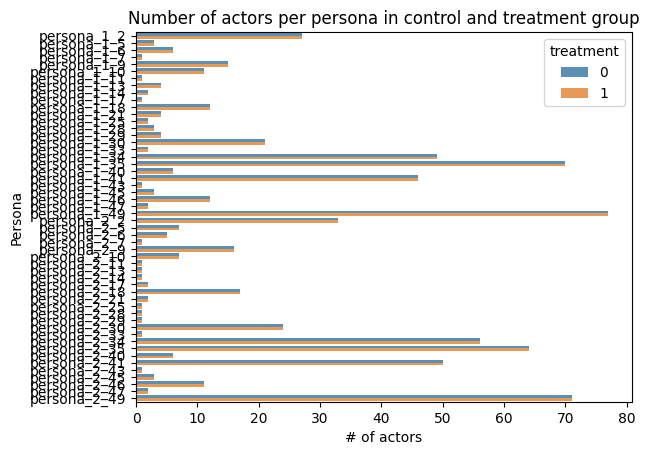

In [217]:
# Sanity check for persona exact matching
matched_persona = pd.get_dummies(matched_actor_feats, columns=['persona_1','persona_2'])
matched_persona = matched_persona[['treatment']+[col for col in matched_persona.columns if 'persona' in col]].groupby('treatment', as_index=False).sum()
matched_persona = matched_persona.melt(id_vars='treatment', value_name='count')

sns.barplot(x='count', y='variable', hue='treatment', data=matched_persona, alpha=0.8)
plt.ylabel('Persona')
plt.xlabel('# of actors')
plt.title('Number of actors per persona in control and treatment group');

In [218]:
matched_actor_feats.groupby('treatment').agg(with_top00_avg=('with_top100','mean'))

,with_top00_avg
treatment,
0,0.0
1,0.0


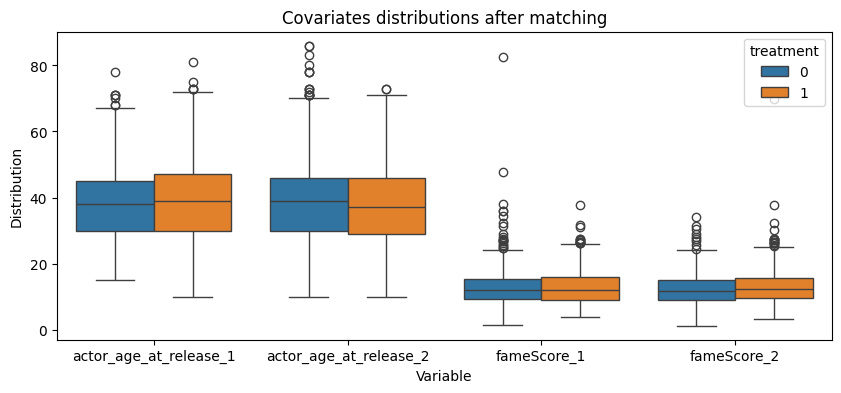

In [219]:
# Sanity check for age at film release for both actors and fameScrore for benefitting actor
matched_actor_feats['actor_age_at_release_1']=matched_actor_feats['actor_age_at_release_1'].astype(int)
matched_actor_feats['actor_age_at_release_2']=matched_actor_feats['actor_age_at_release_2'].astype(int)

plt.figure(figsize=(10,4))
sns.boxplot(data=matched_actor_feats[['actor_age_at_release_1','actor_age_at_release_2','fameScore_1', 'fameScore_2','treatment']]\
                    .melt(value_vars=['actor_age_at_release_1','actor_age_at_release_2','fameScore_1', 'fameScore_2'],
                          id_vars='treatment'),
            y='value',
            x='variable',
            hue='treatment')
plt.title('Covariates distributions after matching')
plt.ylabel('Distribution')
plt.xlabel('Variable');

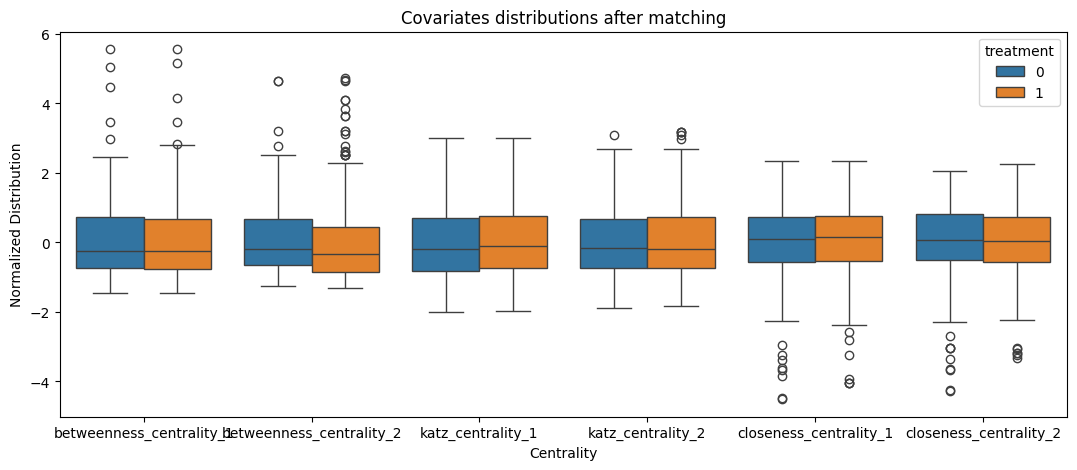

In [220]:
centrality_cols = ['betweenness_centrality_1','betweenness_centrality_2',
                   'katz_centrality_1','katz_centrality_2',
                   'closeness_centrality_1','closeness_centrality_2']
matched_actor_feats[centrality_cols] -= matched_actor_feats[centrality_cols].mean()
matched_actor_feats[centrality_cols] /= matched_actor_feats[centrality_cols].std()

plt.figure(figsize=(13,5))
sns.boxplot(data=matched_actor_feats[centrality_cols+['treatment']]\
                    .melt(value_vars=centrality_cols,
                          id_vars='treatment'),
            y='value',
            x='variable',
            hue='treatment')
plt.title('Covariates distributions after matching')
plt.ylabel('Normalized Distribution')
plt.xlabel('Centrality');

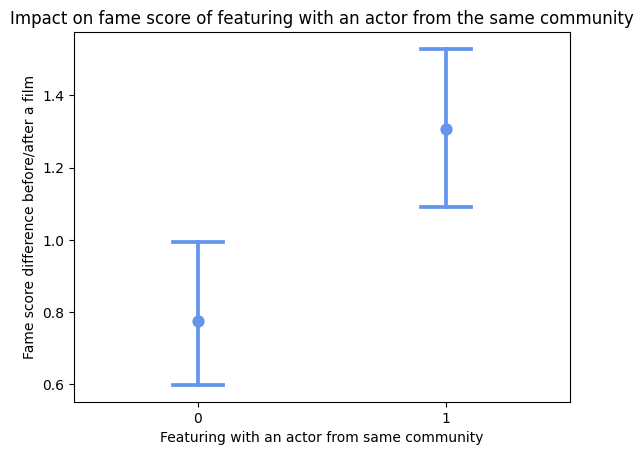

In [221]:
sns.pointplot(data=matched_actor_feats, x='treatment', y='fameScore_diff', color='cornflowerblue', 
              linestyles='none', capsize=0.2)#err_kws={'linewidth': 1}
plt.title('Impact on fame score of featuring with an actor from the same community')
plt.ylabel('Fame score difference before/after a film')
plt.xlabel('Featuring with an actor from same community');

In [222]:
avg_fameScore_diff = matched_actor_feats.groupby('treatment',as_index=False)[['fameScore_diff']]\
                                        .agg(avg=('fameScore_diff','mean'), 
                                             ci=('fameScore_diff',lambda x:1.96*stats.sem(x)))

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=avg_fameScore_diff['treatment'],
    y=avg_fameScore_diff['avg'],
    mode='markers',
    error_y=dict(
        type='data', 
        array=avg_fameScore_diff['ci'],
        visible=True,
        thickness=2.5,
        width=30,
        color='cornflowerblue'
    ),
    marker=dict(
        color='cornflowerblue'
    )    
))

fig.update_layout(xaxis_title='Featuring with an actor from same community', 
                  yaxis_title='Fame score difference before/after a film', 
                  title='Impact on fame score of featuring with an actor from the same community',
                  height=500, 
                  width=600)
fig.update_xaxes(range=[-1, 2])
fig.show()

In [223]:
stats.ttest_ind(matched_actor_feats.query('treatment==False')['fameScore_diff'].values, 
                matched_actor_feats.query('treatment==True')['fameScore_diff'].values)

TtestResult(statistic=-3.609745317997609, pvalue=0.0003263846887362015, df=768.0)

### 2.2 Genre Analysis

In [ ]:
def get_genre_diversity(df):
    '''
    This function returns the number of different past different genres assigned to movies an actor 
    played in before.
    '''
    df = df.sort_values('release_date')
    return pd.DataFrame({'wikiID':df['wikiID'].values,
                         'genre_diversity':[len(np.unique(np.hstack(df.iloc[:i+1]['genre'].values)))
                                            for i in range(df.shape[0])],
                         'movie_diversity':[i+1 for i in range(df.shape[0])]})

# compute a dataframe with actor informations for each film with fame and number of past genres
actor_genres = cmu_character[['wikiID','actor_name','freebase_actorID','fameScore','release_date']] \
                            .merge(cmu_movies[['wikiID','genre']])

actor_genres['genre'] = actor_genres['genre'].apply(lambda x : x[:3]) #keep only the 3 main genres

actor_genres = actor_genres.merge(actor_genres.groupby('freebase_actorID').apply(get_genre_diversity)\
                                                                          .reset_index(level=0),
                                  on=['freebase_actorID','wikiID'])
actor_genres.sample(5)

In [ ]:
mean_genre= actor_genres[['fameScore','genre_diversity']].groupby(by=['genre_diversity'],as_index=False).agg(['median','std','count'])
mean_movie= actor_genres[['fameScore','movie_diversity']].groupby(by=['movie_diversity'],as_index=False).agg(['median','std','count'])

In [ ]:
fig = px.scatter(x=mean_genre[mean_genre['fameScore']['count']>100].index, 
             y=mean_genre[mean_genre['fameScore']['count']>100]['fameScore']['median'], 
             labels={'y': 'Mean Value'})

# Reshape the figure by updating layout parameters
fig.update_layout(
    width=600,  # Set the width of the figure
    height=400,  # Set the height of the figure
    title='',  # Update the title
    xaxis_title='genre diversity',  # Update the X-axis label
    yaxis_title='median fame score',  # Update the Y-axis label
    margin=dict(l=50, r=50, b=50, t=50),  # Adjust margins if needed
)


fig.show()

In [ ]:
fig = px.scatter(x=mean_movie[mean_movie['fameScore']['count']>100].index, 
             y=mean_movie[mean_movie['fameScore']['count']>100]['fameScore']['median'], 
             labels={'y': 'Mean Value'})

# Reshape the figure by updating layout parameters
fig.update_layout(
    width=600,  # Set the width of the figure
    height=400,  # Set the height of the figure
    title='',  # Update the title
    xaxis_title='number of movies played',  # Update the X-axis label
    yaxis_title='median fame score',  # Update the Y-axis label
    margin=dict(l=50, r=50, b=50, t=50),  # Adjust margins if needed
)

fig.show()

In [ ]:
# Calculate the correlation matrix
correlation_matrix = actor_genres[['genre_diversity','movie_diversity','fameScore']]\
                              .corr(method='pearson')

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
actor_mean_n = actor_genres[['fameScore','movie_diversity','genre_diversity']].groupby(by=['movie_diversity','genre_diversity'],as_index=False).agg(['median','std','count']).reset_index()
actor_mean_n = actor_mean_n[actor_mean_n['fameScore']['count']>10]
actor_mean_n

In [ ]:
fig = px.scatter(x=actor_mean_n['genre_diversity'], 
                 y=actor_mean_n['fameScore']['median'], 
                 animation_frame=actor_mean_n['movie_diversity'],
                 range_x=[0,50], range_y=[0,12],
                 #  error_y=mean_fame_diversity['fameScore']['std'],
                 labels={'y': 'Mean Value', 'animation_frame': 'number of movies played'})


# Reshape the figure by updating layout parameters
fig.update_layout(
    width=600,  # Set the width of the figure
    height=400,  # Set the height of the figure
    title='',  # Update the title
    xaxis_title='genre diversity',  # Update the X-axis label
    yaxis_title='median fame score',  # Update the Y-axis label
    margin=dict(l=50, r=50, b=50, t=50),  # Adjust margins if needed
)

fig.show()

In [ ]:
fig = px.scatter(x=actor_mean_n['movie_diversity'], 
                 y=actor_mean_n['fameScore']['median'], 
                 animation_frame=actor_mean_n['genre_diversity'],
                 range_x=[0,70], range_y=[0,12],
                 #  error_y=mean_fame_diversity['fameScore']['std'],
                 labels={'y': 'Mean Value', 'animation_frame': 'genre diversity'})


# Reshape the figure by updating layout parameters
fig.update_layout(
    width=600,  # Set the width of the figure
    height=400,  # Set the height of the figure
    title='',  # Update the title
    xaxis_title='number of movies played',  # Update the X-axis label
    yaxis_title='median fame score',  # Update the Y-axis label
    margin=dict(l=50, r=50, b=50, t=50),  # Adjust margins if needed
)

fig.show()

In [ ]:
mod = smf.ols(formula='fameScore ~ genre_diversity + movie_diversity', data=actor_genres)
res = mod.fit()

print(res.summary())

### 2.3 Persona Analysis

Initially, we discretize the age data into subsets to identify distinct clusters. Subsequently, we assign a group number to each cluster, taking into account factors such as ethnicity, gender, and age at the time of release.

In [ ]:
cplt_character = cmu_character.dropna(subset=['actor_age_at_release','actor_ethnicity','actor_gender','persona']).copy()
bins=[0, 40, 60, 80, 100]
Ages = ['0-40','41-60','61-80','81-100']
cplt_character['actor_age_gr_at_release'] = pd.cut(cplt_character['actor_age_at_release'],bins=bins,labels=Ages)

cplt_character['group'] = cplt_character.groupby(by=['actor_age_gr_at_release','actor_ethnicity','actor_gender']).ngroup()
cplt_character

The following function is defined to determine the group of an actor based on their characteristics:

In [ ]:
def find_group(gender,ethni,age):

    return cplt_character[(cplt_character['actor_gender'] == gender) & 
                (cplt_character['actor_age_gr_at_release'] == age) & 
                (cplt_character['actor_ethnicity'] == ethni)]['group'].unique()[0]

A function is then written to generate a plot illustrating the mean and standard deviation of the differential fame scores for a specified group of actors.

In [ ]:
def plotall(cluster):
    actor_group = cplt_character[cplt_character['group'] == cluster]
    actor_group = actor_group.dropna(subset=['persona']).copy()
    actor_group['persona'] = actor_group['persona'].astype(int)

    actor_group = actor_group[['freebase_char_actor_map', 'fameScore_diff', 'persona']]

    persona_counts = actor_group.groupby('persona',as_index=False).agg('count')
    persona_counts = persona_counts[persona_counts['fameScore_diff']>10]

    actor_group = actor_group.merge(persona_counts['persona'],on='persona')

    actor_group_persona = actor_group[['persona','fameScore_diff']].groupby(by=['persona'],as_index=False).agg(['mean','std'])

    fig = px.scatter(actor_group_persona['fameScore_diff'], x=actor_group_persona.index, y='mean', error_y='std', title='Average Fame Scores with Variance Bars',
                 labels={'avg_fame_score': 'Average Fame Score', 'persona': 'Persona'})

    return fig

Lastly, an application is developed, allowing users to select a group of actors and assess whether a persona is more likely to yield a positive fame score differential or not.

In [ ]:
Genders = cplt_character['actor_gender'].unique()
Ethnis = cplt_character['actor_ethnicity'].unique()
# Dash app
app = dash.Dash(__name__)

app.layout = html.Div([    # fameScore_diff = cplt_character[cplt_character['group']==n]['fameScore_diff']
    html.H1("Interactive Regression Coefficients Plot"),
    html.Div([
    # Dropdown to select cluster
    dcc.Dropdown(
        id='gender-selection',
        options=[
            {'label': str(gender), 'value': gender}
            for gender in Genders
        ],
        value=Genders[0],  # Set default value
        style={'width': '300px'}
    )], style={'display': 'inline-block', 'margin-right': '20px'}),

    html.Div([
    dcc.Dropdown(
        id='ethni-selection',
        options=[
            {'label': str(ethni), 'value': ethni}
            for ethni in Ethnis
        ],
        value=Ethnis[0],  # Set default value
        style={'width': '300px'}
    )], style={'display': 'inline-block', 'margin-right': '20px'}),

    html.Div([
    dcc.Dropdown(
        id='age-selection',
        options=[
            {'label': str(age), 'value': age}
            for age in Ages
        ],
        value=Ages[0],  # Set default value
        style={'width': '300px'}
    )], style={'display': 'inline-block', 'margin-right': '20px'}),
    
    # Graph to display coefficients
    dcc.Graph(id='coefficients-graph')
])

# Callback to update graph based on cluster selection
@app.callback(
    Output('coefficients-graph', 'figure'),
    [Input('gender-selection', 'value'),
     Input('ethni-selection', 'value'),
     Input('age-selection', 'value')]
)
def update_graph(gender,ethni,age):
    cluster = cplt_character[(cplt_character['actor_gender'] == gender) & 
                (cplt_character['actor_age_gr_at_release'] == age) & 
                (cplt_character['actor_ethnicity'] == ethni)]['group'].unique()[0]
    return plotall(cluster)

if __name__ == '__main__':
    app.run_server(debug=True, port=8052)


In the presented analysis, it's evident that none of the personas exhibits a discernible impact on the fameScore_diff. To investigate further into the potential correlation between fameScore_diff and persona within a particular group of actors, we opt to conduct an ANOVA test. This statistical test will help us determine whether there are significant differences in the fameScore_diff among the various personas within the chosen actor group.

In [ ]:
n = 5
fameScore_diff = cplt_character[cplt_character['group']==n]['fameScore_diff']
persona = cplt_character[cplt_character['group']==n][['persona']]
persona_counts = persona.value_counts().to_frame().reset_index()
persona_counts = persona_counts[persona_counts['count']>10]

select_lines = persona['persona'].isin(persona_counts['persona'])
persona = persona[select_lines]['persona']
fameScore_diff = fameScore_diff[select_lines]

f_statistic, p_value = f_oneway(*[fameScore_diff[persona == category] for category in persona.unique()])

print(f'f_statistic : {f_statistic}')
print(f'p_value : {p_value}')

We notice that, for numerous actor groups, the null hypothesis cannot be rejected. Therefore, it can be assumed that the selection of a persona does not exert an influence on whether there is an increase in fameScore or not.

### 2.6 Country Analysis

In this part we'll try to answer the following question : **Is there a better country to play in ?**

The primary goal is to assess the fame scores across major film-producing nations. We will focus on the top five countries with the highest popularity ratings from the provided database

In [ ]:
actor_country= cmu_character[['wikiID','actor_name','freebase_actorID','fameScore','release_date','actor_ethnicity']] \
                            .merge(cmu_movies[['wikiID','country']])
actor_country['country'] = actor_country['country'].apply(lambda x: x[0] if len(x) != 0 else None )

In [ ]:
main_countries = actor_country[['country','wikiID']].groupby(by=['country'],as_index=False).agg('count').sort_values(by=['wikiID'],ascending=False).head(5)
actor_country = actor_country.merge(main_countries['country'],on=['country'])
main_countries

In [ ]:
median_country = actor_country[['country','fameScore']].groupby(by=['country'],as_index=False).agg('median')

actor_country['release_date']=pd.to_datetime(actor_country['release_date']).dt.year
bins = range(actor_country['release_date'].min(),actor_country['release_date'].max() + 6, 5)
actor_country['release_date']= pd.cut(actor_country['release_date'], bins=bins, labels=bins[:-1])
actor_country['release_date'] = pd.to_numeric(actor_country['release_date'], errors='coerce')

In [ ]:
fig = px.bar(
    median_country,
    x='country',
    y='fameScore',
    labels={'fameScore': 'Median Fame Score'},
    title='Median Fame Score by Country',
)

# Update layout parameters
fig.update_layout(
    width=800,
    height=500,
    margin=dict(l=50, r=50, b=50, t=50),
    xaxis_title='Country',
    yaxis_title='Median Fame Score',
)

fig.show()

It is evident that the median fame score is consistently higher in the epicenter of the film industry ('USA'), whereas it is notably low in India.

We believe that actor ethnicity is highly correlated with the country of the movie. Conducting a chi-square analysis could provide evidence supporting this hypothesis.



In [ ]:
# Calculate the correlation matrix
contingency_table = pd.crosstab(actor_country['country'], actor_country['actor_ethnicity'])

# Perform the chi-squared test
chi2, p_value, _, _ = chi2_contingency(contingency_table)

print(f'chi2 : {chi2}')
print(f'p_value : {p_value}')

# Create a Plotly Heatmap
fig = go.Figure(go.Heatmap(
    z=contingency_table.values,
    x=contingency_table.columns,
    y=contingency_table.index,
    colorscale='Blues',
    colorbar=dict(title='Count'),
    zmin=0,
    zmax=contingency_table.max().max(),
))

# Add annotations
for i in range(len(contingency_table.index)):
    for j in range(len(contingency_table.columns)):
        fig.add_annotation(
            x=contingency_table.columns[j],
            y=contingency_table.index[i],
            text=str(contingency_table.iloc[i, j]),
            showarrow=False,
            font=dict(color='white' if contingency_table.iloc[i, j] > contingency_table.max().max() / 2 else 'black')
        )

# Update layout parameters
fig.update_layout(
    title='Correlation Heatmap',
    xaxis=dict(title='country'),
    yaxis=dict(title='actor_ethnicity'),
)

fig.show()

Therefore, our observation suggests that only Asian individuals are likely to be cast in Indian movies, whereas the diversity in the USA is much broader. Now, we aim to understand whether the low fame score is attributed to the Indian ethnicity of the actor or if it is primarily influenced by the country of origin of the movie.

For this reason, we are plotting the median fame score by country specifically for individuals of Asian ethnicity.

In [ ]:
median_country = actor_country[['country','fameScore','actor_ethnicity']].groupby(by=['actor_ethnicity','country'],as_index=False).agg('median')
median_country = median_country[median_country['actor_ethnicity']=='Asian, Middle East and Tribes']
median_country
# Create a line plot
fig = px.bar(
    median_country,
    x='country',  # Assuming release_date is in a datetime format
    y='fameScore',
    labels={'fameScore': 'Fame Score'},
    title='Fame Score Over Time by Country for Asian ethnicity',
)

# Update layout parameters
fig.update_layout(
    width=800,
    height=500,
    margin=dict(l=50, r=50, b=50, t=50),
    xaxis_title='Release Date',
    yaxis_title='median Fame Score',
)

fig.show()

It appears that even for individuals of Asian ethnicity, the advantages in terms of fame score are more pronounced when they are cast in movies produced in the USA.

This observation could be open to discussion based on the origin of the data and the methodology used to compute the fame score. Given that the IMDb dataset was created in the USA, it is plausible to assume that a significant portion of the ratings comes from American or European audiences. Consequently, a tentative conclusion is that, for optimal fame scores among American audiences, an actor may find it beneficial to participate in productions based in the USA or Europe. However, further analysis and considerations may be needed to validate and refine this conclusion.

#### Does these conclusions constant in time ?

In [ ]:
median_country = actor_country[['country','fameScore','release_date']].groupby(by=['release_date','country'],as_index=False).agg('median')
median_country

# Create a line plot
fig = px.line(
    median_country,
    x='release_date',  # Assuming release_date is in a datetime format
    y='fameScore',
    color='country',
    labels={'fameScore': 'Fame Score'},
    title='Fame Score Over Time by Country',
)

# Update layout parameters
fig.update_layout(
    width=800,
    height=500,
    margin=dict(l=50, r=50, b=50, t=50),
    xaxis_title='Release Date',
    yaxis_title='Median Fame Score',
)

fig.show()

It's interesting to note that for older dates, data limitations may affect the analysis due to insufficient information. On the other hand, when examining more recent data, there doesn't seem to be any discernible change over time. This stability in patterns could suggest a consistent trend in the relationship between actor location and fame scores, emphasizing the enduring influence of factors like movie origin on audience recognition.

In [ ]:
limit_year = 1980
actor_country = actor_country[actor_country['release_date']>limit_year]
median_country = median_country[median_country['release_date']>limit_year]
# Create a line plot
fig = px.line(
    median_country,
    x='release_date',  # Assuming release_date is in a datetime format
    y='fameScore',
    color='country',
    labels={'fameScore': 'Fame Score'},
    title='Fame Score Over Time by Country',
)

# Update layout parameters
fig.update_layout(
    width=800,
    height=500,
    margin=dict(l=50, r=50, b=50, t=50),
    xaxis_title='Release Date',
    yaxis_title='Fame Score',
)

fig.show()